# Forecasting organic growth

## Imports

In [1]:
PATH_OUT = '/Users/ahmed/Projects/gm_tool/assets/'

In [26]:
import sys
import pandas as pd
import datetime as dt
import numpy as np
import time

from pytrends.request import TrendReq as UTrendReq
import requests

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('whitegrid')

from prophet import Prophet
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from tqdm.notebook import tqdm
from IPython.display import display, HTML

sys.path.insert(0,"/Users/ahmed/Projects/gm_tool/")
from datamanager.DM_USA import DM_USA

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Preprocessing 

In [2]:
country = "USA"
brands_name = {"BELGIUM": ["APERICUBE", "BABYBEL", "BOURSIN", "KIRI", "MINI BABYBEL", "VACHE QUI RIT", "MAREDSOUS"],
     "USA": ["BABYBEL", "THE LAUGHING COW", "BOURSIN", "KAUKAUNA", "MERKTS", "PRICES", "NURISHH"]}
aandp_brands_name = {"BELGIUM": ["APERICUBE", "BABYBEL", "BOURSIN", "KIRI", "MINI BABYBEL", "VACHE QUI RIT", "MAREDSOUS"],
    "USA": ["000BQ - BOURSIN", "000LA - THE LAUGHING COW", "000MB - MINI BABYBEL", "000KC - KAUKAUNA", "000PG - PRICE'S", "000MI - MERKTS", "003NH - NURISHH"]}
features = ["Date", "Brand", "Category", "Distribution", "Price per volume", "Sales in volume"]

In [4]:
# Loading dataframe using datamanager
data_manager = DM_USA(brands_name[country], aandp_brands_name[country])
df_bel = data_manager.get_df_bel()
df = data_manager.get_df()
df.head()
df_bel.head()

page 1/14
page 2/14
page 3/14
page 4/14
page 5/14
page 6/14
page 7/14
page 8/14
page 9/14
page 10/14
page 11/14
page 12/14
page 13/14
page 14/14


/Users/ahmed/Projects/gm_tool/datamanager/DM_USA.py:71: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ['Date', 'Brand'], as_index=False)['Distribution', 'Price per volume', 'Sales in volume'].agg(


columns and types are correct


,Date,Category,Sub Category,Brand,Sales in value,Sales in volume,Distribution,Price per volume,Price without promo,Sales value with promo,Sales volume with promo,Period
0,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,285.014421,25.961137,0.013007,10.978503,10.978503,NaN,NaN,1
1,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,AUTHENTIC MENU,1205.790000,242.500000,1.980134,4.972330,4.994717,5.277200,2.145000,1
2,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,APPEL FARM QUARK,391.079899,80.904125,0.151621,4.833868,4.966977,4.796178,2.756167,1
3,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,ASHBYS,3909.132137,327.681769,0.848531,11.929660,12.025146,53.182613,6.832235,1
4,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,NEW BRIDGE,27112.449008,2707.353139,7.551650,10.014375,10.455282,995.316059,184.093633,1


,Date,Brand,Distribution,Price per volume,Sales in volume,A&P,Rate of Innovation,Promo Cost,HH
0,2017-12-31,BABYBEL,417.403475,11.307482,250446.559440,NaN,0.0,NaN,NaN
1,2017-12-31,BOURSIN,152.671400,13.745852,85626.196096,NaN,0.0,NaN,NaN
2,2017-12-31,KAUKAUNA,173.182554,6.703015,444672.382865,NaN,0.0,NaN,NaN
3,2017-12-31,MERKTS,77.224967,5.383924,88166.774383,NaN,0.0,NaN,NaN
4,2017-12-31,PRICES,93.366316,4.762444,108331.433158,NaN,0.0,NaN,NaN


In [186]:
df = pd.read_excel('data/USA_df_postprocessing_0303.xlsx')

In [187]:
df_bel = pd.read_excel('data/USA_df_bel_0303.xlsx')

In [188]:
df.describe()
df_bel.describe()

,Sales in value,Sales value with promo,Sales in volume,Sales volume with promo,Price without promo,Price with promo,Price per volume,Distribution,Period
count,5.618450e+05,3.319400e+05,5.616510e+05,3.319140e+05,556360.000000,331914.000000,561651.000000,561851.000000,561851.000000
mean,1.560801e+05,2.536450e+04,3.050336e+04,7.183366e+03,10.998721,9.323602,10.724612,15.021705,104.071197
std,1.731295e+06,2.640968e+05,4.292492e+05,8.477446e+04,6.966822,5.689281,6.838948,111.353966,59.940493
min,1.059592e-02,-2.061822e+04,3.374096e-03,0.000000e+00,0.004545,0.020000,0.004545,0.000008,1.000000
25%,5.094914e+02,1.630839e+01,5.169279e+01,3.122572e+00,5.926933,5.190934,5.757340,0.057040,52.000000
50%,2.518780e+03,1.833527e+02,2.896750e+02,3.065530e+01,8.990000,7.929900,8.728550,0.304649,104.000000
75%,1.424689e+04,1.576589e+03,1.622736e+03,2.810669e+02,14.256434,11.980000,13.936014,2.112577,156.000000
max,1.080815e+08,2.069495e+07,2.791777e+07,5.769725e+06,111.840000,111.840000,111.840000,3286.000649,209.000000


,Price per volume,Sales in volume,Sales in value,Distribution,Sell-in,Advertising,Promotion,A&P,MVC,Rate of Innovation,Promo Cost,HH
count,1290.000000,1290.000000,1.290000e+03,1290.000000,1.284000e+03,1284.000000,1284.000000,1.284000e+03,1.284000e+03,1254.000000,9.720000e+02,1248.000000
mean,9.711234,162125.343108,1.466125e+06,112.370019,1.042795e+06,468.563419,180.197304,1.483993e+05,3.517348e+05,0.056198,1.311533e+05,0.118627
std,3.934358,130600.480349,1.413531e+06,79.900971,1.168932e+06,751.997698,229.443496,2.079499e+05,5.032372e+05,0.167690,1.995524e+05,0.131695
min,4.356190,33.244110,4.593722e+02,0.106678,-1.306417e+03,0.000000,0.476932,5.590334e+02,-2.230124e+03,0.000000,0.000000e+00,0.000000
25%,6.656784,59169.502380,5.304450e+05,59.829339,2.595571e+05,7.020648,24.314749,1.002405e+04,2.979779e+02,0.000000,1.162927e+04,0.000000
50%,8.214918,110994.645919,7.593131e+05,91.803154,4.935925e+05,98.394032,80.457900,4.787216e+04,1.032955e+05,0.000000,3.496581e+04,0.085845
75%,13.127200,247810.062772,2.009003e+06,144.134090,1.256272e+06,587.111062,253.779553,1.999614e+05,5.255385e+05,0.044170,1.753168e+05,0.207211
max,18.750507,634634.168587,6.431016e+06,453.794758,4.899662e+06,3834.525990,1405.353723,1.039757e+06,2.278523e+06,0.945625,1.363849e+06,0.635718


Dictionary of brand's markets.

In [6]:
brands_markets = {brand: df[df.Brand == brand].Category.unique().tolist() for brand in brands_name[country]}
bel_markets = list(set([elem for brand in brands_markets for elem in brands_markets[brand]]))
brands_markets
bel_markets

{'BABYBEL': ['SNACK', 'SNACKING COMBOS'],
 'THE LAUGHING COW': ['CLASSIC SPREADS', 'SNACK', 'SNACKING COMBOS'],
 'BOURSIN': ['GOURMET SPREADS', 'PLANT BASED'],
 'KAUKAUNA': ['CLASSIC SPREADS', 'GOURMET SPREADS', 'SNACK'],
 'MERKTS': ['CLASSIC SPREADS', 'SNACK'],
 'PRICES': ['PIMENTO', 'SNACK'],
 'NURISHH': ['PLANT BASED']}

['PLANT BASED',
 'GOURMET SPREADS',
 'SNACKING COMBOS',
 'CLASSIC SPREADS',
 'SNACK',
 'PIMENTO']

In [155]:
def forecasting_one_brand(df, brand_name, features_name, simulations_params=[], periods=36, freq='MS'):
    """ Forecasting giving brand_name for giving number of periods and 
    features to use. 
    """
    # Get DataFrame for brand_name
    df = df.groupby(["Brand", "Date"]).agg(
        "sum").loc[brand_name].reset_index().sort_values('Date')
    # Predict long-term forecast for features
    print("OKKKKK 00000")
    display(df[features_name])
    df_features = forecasting_features(df, features_name, periods=periods, freq=freq)
    print("OKKKKK 11111")
    display(df_features)
    print("OKKKKK 22222")
    display(df)
    # Preprocessing dataframe for prophet
    df['Date'] = pd.to_datetime(df.Date)
    df = pd.merge(df_features, df[['Date', 'Sales in volume']], on='Date')
    df.rename(columns={'Date': 'ds', 'Sales in volume': 'y'}, inplace=True)
    print("OKKKKK 33333")
    display(df)


    # Instanciating Prophet Model
    model = Prophet(growth='logistic', yearly_seasonality=20)
    # Adding regressors
    for feature in features_name:
        model.add_regressor(feature)

    # Fitting model
    model.fit(df)
    future = model.make_future_dataframe(periods=periods, freq=freq)

    for feature in features_name:
        future[feature] = df_features[feature]

    # Predicting sales forecasts
    fcst = model.predict(future)

    df_brand_fcst = pd.DataFrame()
    df_brand_fcst["Date"] = df_features["Date"]
    df_brand_fcst[brand_name+" Sales in volume"] = fcst["yhat"]

    return df_brand_fcst


def forecasting_brands(df, brands_name, features_name, periods=36, freq='MS'):
    """Forecasting a list of brands using the given features and periods
    """

    list_df_brands = []
    # Compute forecast for each brand
    for brand in tqdm(brands_name, ascii=True, desc='Brands'):
        list_df_brands.append(
            forecasting_one_brand(df, brand, features_name, simulations_params=[], periods=periods, freq=freq))

    # Merge results of each brand
    df_brands_fcst = list_df_brands[0].Date
    for df_tmp in list_df_brands:
        df_brands_fcst = pd.merge(df_brands_fcst, df_tmp, on='Date')

    return df_brands_fcst

In [63]:
forecasting_one_brand(df_bel, 'BABYBEL', features_name, simulations_params=[], periods=157, freq='W')

OKKKKK 00000


,Distribution,A&P,Rate of Innovation,HH,Trends,Price without promo,Price per volume,Promo Cost
0,417.403475,0.000000,0.000000,0.000000,19,11.752261,11.307482,0.00000
1,447.141103,488628.056575,0.000000,0.307374,21,11.313712,10.935915,0.00000
2,452.634493,488628.056575,0.000000,0.337162,21,10.607967,10.578783,0.00000
3,447.468282,488628.056575,0.000000,0.334470,24,10.696598,10.644737,0.00000
4,445.936354,488628.056575,0.000000,0.299464,19,10.934500,10.612370,0.00000
...,...,...,...,...,...,...,...,...
204,287.146247,575225.417350,0.093991,0.396317,32,28.610238,27.829845,63567.51658
205,303.205534,746154.761700,0.109031,0.476843,44,28.555896,28.170270,26187.61672
206,303.356756,746154.761700,0.107922,0.485625,36,29.079173,28.950699,25709.56930
207,305.677351,746154.761700,0.102776,0.463249,30,28.796125,28.656470,31065.64238


Features:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.82079
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       562.175   0.000785939       85.4929      0.5096      0.5096      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       563.331   7.05051e-05       66.0672       1.868      0.5537      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       563.345   0.000125008       79.1417   1.464e-06       0.001      370  LS failed, Hessian reset 
     299       563.352   7.28088e-08       73.9971      0.5955      0.5955      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       563.353   1.79349e-06       70.5759   2.195e-08       0.001      480  LS failed, Hessian reset 
     328       563.353   1.42802e-08       66.8817      0.1964           1      503   
Optimization terminat

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.1363
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       284.812    0.00283614       69.9102   5.607e-05       0.001      141  LS failed, Hessian reset 
      99       284.892   0.000101416       56.8066      0.9319      0.9319      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       284.898   2.91963e-05        61.989   4.091e-07       0.001      222  LS failed, Hessian reset 
     165       284.899   1.54983e-06       62.2764   1.983e-08       0.001      330  LS failed, Hessian reset 
     170       284.899   9.14981e-09       55.5443     0.02198     0.09907      337   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -14.6857
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       185.161   0.000580424       87.4136   7.527e-06       0.001      145  LS failed, Hessian reset 
      99        185.21   9.18195e-06       78.7335           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       185.213   1.51544e-05       91.3953   2.019e-07       0.001      218  LS failed, Hessian reset 
     147       185.215   4.86931e-06       74.1674   5.897e-08       0.001      312  LS failed, Hessian reset 
     178       185.215   6.19987e-07       87.1668   8.117e-09       0.001      394  LS failed, Hessian reset 
     190       185.215   7.31629e-09       75.2271      0.1839      0.1839      410   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -20.8233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       398.377    0.00184862       64.1693           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       398.459   0.000215301        51.378   6.839e-06       0.001      221  LS failed, Hessian reset 
     131       398.492   3.40303e-05       62.0426    7.24e-07       0.001      290  LS failed, Hessian reset 
     184       398.638   0.000208719       60.5759   3.838e-06       0.001      413  LS failed, Hessian reset 
     199       398.653   3.56943e-05       53.9147       0.312      0.9149      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       398.663   3.40554e-07       53.0481   9.506e-09       0.001      515  LS failed, Hessian reset 
     226       398.663   3.45644e-08        35.823     0.03262   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.73434
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       384.965    0.00306879        89.199   3.398e-05       0.001      176  LS failed, Hessian reset 
      99       385.161   0.000206075       78.3101       0.246           1      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       385.207   8.19706e-05       65.3269   9.884e-07       0.001      270  LS failed, Hessian reset 
     180       385.214   6.57478e-05       67.3901   7.896e-07       0.001      369  LS failed, Hessian reset 
     199       385.217   1.66147e-06       80.6002       0.886       0.886      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       385.218   4.87017e-06       69.5571   5.898e-08       0.001      461  LS failed, Hessian reset 
     253       385.218   4.13852e-09       74.0339     0.02848   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.96878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       416.963    0.00929197       199.539   8.533e-05       0.001      150  LS failed, Hessian reset 
      99       418.342    0.00281235       108.506           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       418.864   4.23532e-06       78.9024   4.833e-08       0.001      287  LS failed, Hessian reset 
     183       418.865   3.31258e-08       74.5994      0.4465      0.4465      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.14885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.162    0.00279538       159.842   2.245e-05       0.001      176  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       415.729   0.000285117       77.8658   3.299e-06       0.001      287  LS failed, Hessian reset 
     199       415.746   8.85358e-07       89.5128      0.5539      0.5539      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       415.748   1.21358e-05       73.5398   1.328e-07       0.001      394  LS failed, Hessian reset 
     262       415.749   3.00786e-07       84.3414   3.684e-09       0.001      520  LS failed, Hessian reset 
     270       415.749   6.88686e-09        69.523      0.2895      0.2895      530   
Optimization terminated normally: 
  Convergence detected: absolu

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.267
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       315.376   8.78807e-06       83.5185      0.1209      0.1209      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       315.379   6.45105e-09       86.4063       0.161       0.161      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
OKKKKK 11111


,Date,Distribution,A&P,Rate of Innovation,HH,Trends,Price without promo,Price per volume,Promo Cost
0,2017-12-31,425.495649,327808.016546,-0.068704,0.319551,21.030851,15.791696,16.285099,-418197.622153
1,2018-01-07,433.465523,504621.838100,-0.036153,0.365634,26.609019,15.439593,15.655112,-126379.769080
2,2018-01-14,443.992196,618509.689772,-0.012372,0.428865,30.065610,15.317799,14.988000,1138.013791
3,2018-01-21,451.564523,640035.220420,-0.006516,0.466637,29.794820,15.351313,14.536070,-78013.206116
4,2018-01-28,452.560697,648440.214989,-0.012825,0.459907,27.984708,15.495974,14.499320,-234921.863604
...,...,...,...,...,...,...,...,...,...
361,2024-12-01,-186.687242,520566.033916,0.196874,0.506766,35.387815,27.976109,27.864984,182466.829867
362,2024-12-08,-189.930377,549980.867943,0.189509,0.511431,34.934979,28.170903,27.704634,181464.580341
363,2024-12-15,-195.478390,509447.035679,0.179261,0.491622,33.048280,28.151477,27.532033,150119.074881
364,2024-12-22,-201.424651,495983.491909,0.179128,0.457795,32.408706,27.719853,27.257415,209587.656631


OKKKKK 22222


,Date,Sales in value,Sales in volume,Distribution,Price per volume,Price without promo,Sales value with promo,Sales volume with promo,Period,A&P,Rate of Innovation,Promo Cost,HH,Trends
0,2017-12-31,2.831920e+06,250446.559440,417.403475,11.307482,11.752261,56006.854295,6253.412253,1,0.000000,0.000000,0.00000,0.000000,19
1,2018-01-07,3.780414e+06,345687.914295,447.141103,10.935915,11.313712,335535.201544,41085.049654,2,488628.056575,0.000000,0.00000,0.307374,21
2,2018-01-14,4.257673e+06,402472.872702,452.634493,10.578783,10.607967,504167.464941,62277.098406,3,488628.056575,0.000000,0.00000,0.337162,21
3,2018-01-21,4.089279e+06,384159.741534,447.468282,10.644737,10.696598,492255.127195,57868.076398,4,488628.056575,0.000000,0.00000,0.334470,24
4,2018-01-28,4.050880e+06,381713.098609,445.936354,10.612370,10.934500,527113.772708,63877.686381,5,488628.056575,0.000000,0.00000,0.299464,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2021-11-28,3.168579e+06,278930.378607,287.146247,27.829845,28.610238,25495.353044,3327.285786,410,575225.417350,0.093991,63567.51658,0.396317,32
205,2021-12-05,3.749656e+06,324876.537339,303.205534,28.170270,28.555896,37336.678306,5089.111759,412,746154.761700,0.109031,26187.61672,0.476843,44
206,2021-12-12,3.803546e+06,327187.874765,303.356756,28.950699,29.079173,31736.951236,4260.445466,414,746154.761700,0.107922,25709.56930,0.485625,36
207,2021-12-19,3.807657e+06,333108.869011,305.677351,28.656470,28.796125,37978.945261,4318.020306,416,746154.761700,0.102776,31065.64238,0.463249,30


OKKKKK 33333


,ds,Distribution,A&P,Rate of Innovation,HH,Trends,Price without promo,Price per volume,Promo Cost,y
0,2017-12-31,425.495649,327808.016546,-0.068704,0.319551,21.030851,15.791696,16.285099,-418197.622153,250446.559440
1,2018-01-07,433.465523,504621.838100,-0.036153,0.365634,26.609019,15.439593,15.655112,-126379.769080,345687.914295
2,2018-01-14,443.992196,618509.689772,-0.012372,0.428865,30.065610,15.317799,14.988000,1138.013791,402472.872702
3,2018-01-21,451.564523,640035.220420,-0.006516,0.466637,29.794820,15.351313,14.536070,-78013.206116,384159.741534
4,2018-01-28,452.560697,648440.214989,-0.012825,0.459907,27.984708,15.495974,14.499320,-234921.863604,381713.098609
...,...,...,...,...,...,...,...,...,...,...
204,2021-11-28,283.255568,460089.896841,0.162217,0.507310,35.364736,28.163233,27.620592,217180.361793,278930.378607
205,2021-12-05,280.809153,526950.642649,0.158577,0.516141,35.809344,28.342952,27.493722,240588.831104,324876.537339
206,2021-12-12,276.294370,511535.502060,0.148329,0.508879,34.368950,28.463310,27.326290,212981.763487,327187.874765
207,2021-12-19,270.108546,470786.640939,0.141828,0.477841,32.754029,28.227278,27.119619,213432.642096,333108.869011


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.6042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        514.65   1.90409e-05       88.4749           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       515.022    0.00132885       170.794    7.56e-06       0.001      179  LS failed, Hessian reset 
     181       515.322   1.48956e-05       98.1442   1.708e-07       0.001      295  LS failed, Hessian reset 
     199       515.323   3.12411e-07       89.5869           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       515.323   1.83962e-08       93.5018      0.4431           1      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,Date,BABYBEL Sales in volume
0,2017-12-31,287179.587345
1,2018-01-07,314285.258016
2,2018-01-14,357243.704062
3,2018-01-21,393057.683543
4,2018-01-28,400263.064866
...,...,...
361,2024-12-01,265915.206671
362,2024-12-08,266559.542181
363,2024-12-15,263844.534236
364,2024-12-22,256772.649628


In [63]:
df.head()

,Date,Market,Category,Sub Category,Brand,Sales in value,Sales value with promo,Sales in volume,Sales volume with promo,Price without promo,Price with promo,Price per volume,Distribution,Period
0,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,285.014421,NaN,25.961137,NaN,10.978503,NaN,10.978503,0.013007,1
1,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,AUTHENTIC MENU,1205.790000,5.277200,242.500000,2.145000,4.994717,3.637500,4.972330,1.980134,1
2,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,APPEL FARM QUARK,391.079899,4.796178,80.904125,2.756167,4.966977,3.365000,4.833868,0.151621,1
3,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,ASHBYS,3909.132137,53.182613,327.681769,6.832235,12.025146,10.709200,11.929660,0.848531,1
4,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,NEW BRIDGE,27112.449008,995.316059,2707.353139,184.093633,10.455282,8.365867,10.014375,7.551650,1


In [183]:
def get_df_brands(data_manager, country, brands_name, features):
    """Get the right DataFrame giving the country, the brands and features 
    from the datamanager
    """
    df_res = df[df.Brand.isin(
        brands_name[country])][features]
    df_res = df_res.dropna()

    return df_res

def get_df_competition_brands(df, brands_name, features):
    """Get the dataframe of all the other brands except the given ones with 
    the specified features
    """
    df_res = df[~(df.Brand.isin(
        brands_name)) & (df.Category.isin(
        bel_markets))][features]
    df_res = df_res.dropna()
    
    return df_res

def get_df_markets(df):
    """Get Markets dataframe
    """
    df_res = df.groupby(['Category', 'Date']).agg("sum")[
        ['Sales in volume']].unstack(0)
    df_res = df_res.droplevel(level=0, axis=1).reset_index()
    df_res['TOTAL CHEESE'] = df_res.iloc[:, 1:].sum(axis=1)
    df_res = df_res.dropna()
    df_res.columns.name = ''

    return df_res


def forecasting_features(df, features, periods=36, freq='MS'):
    """Get long term forecasts for features giving the dataframe and periods
    """
    # Select features except the target
    list_df_features = []
    for feature in tqdm(features, ascii=True, desc='Features'):
        model = Prophet()
        # Preprocessing Inputs of Prophet
        df_frcast = df[['Date', feature]]
        df_frcast.columns = ['ds', 'y']
        df_frcast.ds = pd.to_datetime(df_frcast.ds)
        df_frcast['cap'] = df[feature].max() * 3
        df_frcast['floor'] = df[feature].mean() / 2
        # Model
        model = Prophet(growth='logistic', yearly_seasonality=20)
        model.fit(df_frcast)

        # Periods is in months
        future = model.make_future_dataframe(periods=periods, freq=freq)
        future['cap'] = df[feature].max() * 3
        future['floor'] = df[feature].mean() / 2
        fcst = model.predict(future[future.ds > df_frcast.ds.iloc[-1]])
        print("AAAAAAAAAAAAAA")
        print(fcst)
        model.plot(fcst)
        df_frcast.rename(columns={'y': feature}, inplace=True)
        fcst.rename(columns={'yhat': feature}, inplace=True)
        # Adding result to list
        list_df_features.append(pd.concat([df_frcast.iloc[:, :-2], fcst[['ds', feature]]]))

    # Merging the dataframes of each feature
    df_features = list_df_features[0][['ds']]
    for dff in list_df_features:
        df_features = pd.merge(df_features, dff, on='ds')

    df_features.rename(columns={'ds': 'Date'}, inplace=True)
    return df_features


def forecasting_one_brand(df, brand_name, features_name, periods=36, freq='MS'):
    """ Forecasting giving brand_name for giving number of periods and 
    features to use. 
    """
    # Get DataFrame for brand_name
    df = df.groupby(["Brand", "Date"]).agg(
        "sum").loc[brand_name].reset_index().sort_values('Date')
    
    # Predict long-term forecast for features
    df_features = forecasting_features(df, features_name, periods=periods, freq=freq)
    # Preprocessing dataframe for prophet
    df['Date'] = pd.to_datetime(df.Date)
    #df = pd.merge(df_features_train, df[['Date', 'Sales in volume']], on='Date', how='inner')
    df = df[['Date', *features_name, 'Sales in volume']]
    df.rename(columns={'Date': 'ds', 'Sales in volume': 'y'}, inplace=True)
    
    # Instanciating Prophet Model
    model = Prophet(growth='logistic', yearly_seasonality=20)
    # Adding regressors
    for feature in features_name:
        model.add_regressor(feature)

    # Fitting model
    model.fit(df)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    if brand_name == "PRICES":
        future['floor'] = 95000
    for feature in features_name:
        future[feature] = df_features[feature]

    # Predicting sales forecasts
    fcst = model.predict(future[future.ds > df.ds.iloc[-1]])
    fcst.rename(columns={'yhat':'y'}, inplace=True)
    df_brand_fcst = pd.concat([df[['ds', 'y']], fcst[['ds', 'y']]])
    df_brand_fcst.rename(columns={'ds': 'Date', 'y':brand_name}, inplace=True)
    # df_brand_fcst = pd.DataFrame()
    # df_brand_fcst["Date"] = df_features["Date"]
    # df_brand_fcst[brand_name+" Sales in volume"] = fcst["yhat"]

    return future, df_brand_fcst


def forecasting_brands(df, brands_name, features_name, periods=36, freq='MS'):
    """Forecasting a list of brands using the given features and periods
    """

    
    dict_feats_futures = {}
    list_df_brands = []
    # Compute forecast for each brand
    for brand in tqdm(brands_name, ascii=True, desc='Brands'):
        future, brand_fcst = forecasting_one_brand(df, brand, features_name, periods=periods, freq=freq)
        dict_feats_futures[brand] = future
        list_df_brands.append(brand_fcst)

    # Merge results of each brand
    df_brands_fcst = list_df_brands[0].Date
    for df_tmp in list_df_brands:
        df_brands_fcst = pd.merge(df_brands_fcst, df_tmp, on='Date', how='outer')

    return dict_feats_futures, df_brands_fcst


def forecasting_markets(df, markets_name, periods=36, freq='MS'):
    """Forecasting list of markets for the given periods
    """
    df_features = forecasting_features(df, markets_name, periods=periods, freq=freq)

    return df_features

def mitigate_covid(df, features, dates):
    """
    """
    pass
    
# Get adjusted features for organic growth
def adjust_organic_growth_features(df_features):
    """Adjust organic growth features for computing correlation of growth
    Drivers in the future (forecast)
    """
    df_organicforecast_feature = df_features.copy()
    feature_columns = list(df_organicforecast_feature)[1:]
    controlable_features = feature_columns[:4]
    df_organic_forecast_feature["Distribution"] = 0
    df_organic_forecast_feature["Rate of innovation"] = 0
    price_75percentile = df_organic_forecast_feature["Price per volume"].quantile(
        0.75)
    df_organic_forecast_feature["Price per volume"] = df_organic_forecast_feature["Price per volume"].apply(
        lambda x: x*1.25 if x <= price_75percentile else x)
    TDP_75percentile = df_organic_forecast_feature["TDP"].quantile(0.75)
    df_organic_forecast_feature["TDP"] = df_organic_forecast_feature["TDP"].apply(
        lambda x: x*0.75 if x >= TDP_75percentile else x)
    
    return df_organic_forecast_feature

In [153]:
df_tmp_bel = df_bel.set_index('Date').loc["2019-01-01":"2021-12-31"]

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

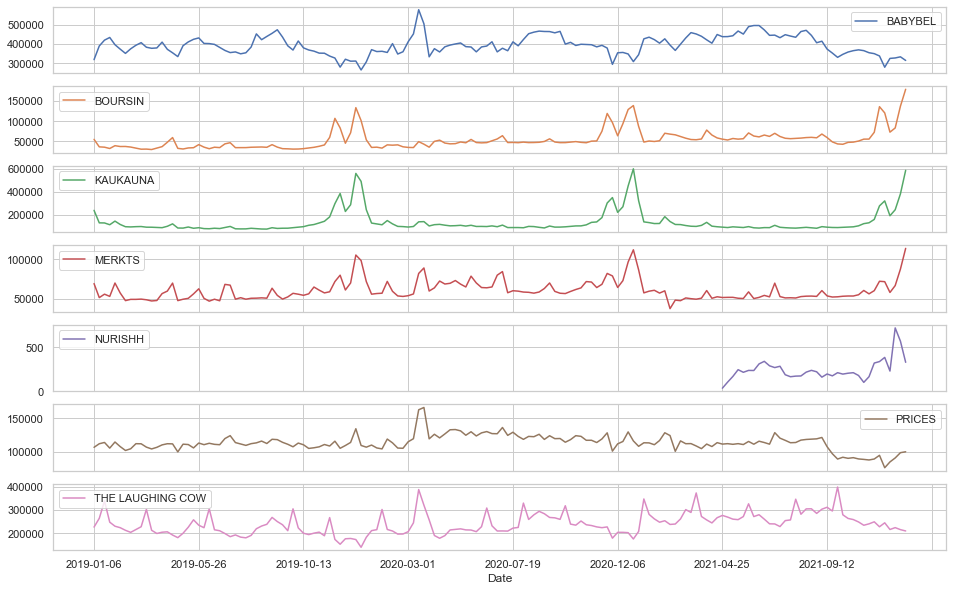

In [154]:
df_tmp_bel.reset_index().groupby(['Date', 'Brand']).agg('sum').unstack()['Sales in volume'].plot(subplots=True, figsize=(16, 10))

## Computing Trends

In [9]:
kw_list = brands_name[country]
timeframes = list(df_bel.Date.unique())
tdelta = dt.timedelta(weeks=1)
timeframes.insert(0, (dt.datetime.strptime(timeframes[0], '%Y-%m-%d') - tdelta).strftime('%Y-%m-%d'))
    
geo='US'
GET_METHOD='get'
headers = {
'authority': 'trends.google.com',
'cache-control': 'max-age=0',
'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="98", "Google Chrome";v="98"',
'sec-ch-ua-mobile': '?0',
'sec-ch-ua-platform': '"macOS"',
'upgrade-insecure-requests': '1',
'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36',
'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
'x-client-data': 'CJ7fygE=',
'sec-fetch-site': 'same-origin',
'sec-fetch-mode': 'navigate',
'sec-fetch-user': '?1',
'sec-fetch-dest': 'document',
'referer': 'https://trends.google.com/trends/?geo='+geo,
'accept-language': 'fr-FR,fr;q=0.9,en-US;q=0.8,en;q=0.7',
'cookie': '__utma=10102256.2142090120.1645455402.1645455402.1645455402.1; __utmc=10102256; __utmz=10102256.1645455402.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); __utmt=1; __utmb=10102256.5.9.1645455408893; CONSENT=YES+srp.gws-20220217-0-RC1.fr+FX+004; 1P_JAR=2022-02-21-15; SID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEa8TFYSMqHR-5OUrj7OtQx_A.; __Secure-1PSID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEawJmkuoBDtYla3S3m5hx8kQ.; __Secure-3PSID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEaG7QfexXpqx5lg43EMUQUQw.; HSID=A_K65lvXgt3Scuc0n; SSID=Ajaw0EKPT7Ok638qm; APISID=1gdUaeoAbGY0hQBG/A68-B5BtWRxthyMoo; SAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; __Secure-1PAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; __Secure-3PAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; NID=511=odIcinna2wJGUmMhN_uM0o_utTxPmkP7IP3WPOfwUDcgDxNaSaK0g-JdjZ15JWlWHpgSqsD2-DFJcy4-F8KfN5oGoz3dsqRKBpr0cgLmyefwq5Dsd2fLlSUh9HJhga7TaUfRKSdu09XitvJ8nCdnGN4iDLenCzdI5qEfyHyB3wJAZyONpYd-P1JtXD56OKnm-wJ5JoJObdm67M_myZj4PiOjMvOeVvnAMVHnZee48Ho; SIDCC=AJi4QfF7GP5rUgjZhMuSVECtziYI-TgFSUpdgGLTnDwYSuP22BrKzLUpdkcYO4aLQjG4jg09; __Secure-3PSIDCC=AJi4QfGKL18okfSNCPOhtb0IHAOOHOOROq_xm0P_hN0fwHW0il9jxtNj4ChDoxtjdexO_l6d',
}

class TrendReq(UTrendReq):
    def _get_data(self, url, method=GET_METHOD, trim_chars=0, **kwargs):
        return super()._get_data(url, method=GET_METHOD, trim_chars=trim_chars, headers=headers, **kwargs)

def compute_trends(geo, kw_list, timeframes):
    """
    """

    pytrend = TrendReq(hl=geo, tz=360)
    dataset = []
    for i in tqdm(range(1, len(timeframes)), desc='TimeFrames', ascii=True):
        # Merge kw queries results, only 5 max can be queried in an iteration
        tmp_data_raw = [timeframes[i]]
        for j in range(0, len(kw_list), 5):
            # 5: because only 5 keywords can be computed at the same time
            pytrend.build_payload(
                kw_list=kw_list[j:j+5],
                timeframe='{} {}'.format(timeframes[i-1], timeframes[i]), 
                geo=geo,
                gprop='')
            data = pytrend.interest_over_time().sum(axis=0)
            # [:-1] in order to not take into account the isPartial column 
            tmp_data_raw += list(data.values)[:-1]
        dataset.append(tmp_data_raw)

    df_trends = pd.DataFrame(dataset, columns=['Date'] + kw_list)
    return df_trends

def compute_trends_bis(geo, kw_list, start_date, end_date):
    """
    """
    pytrend = TrendReq(hl=geo, tz=360)
    dataset = pd.DataFrame()
    for i in range(0, len(kw_list), 5):
        pytrend.build_payload(
            kw_list=kw_list[i:i+5],
            timeframe='{} {}'.format(start_date, end_date),
            geo=geo,
            gprop=''
        )
        data = pytrend.interest_over_time()
        dataset = pd.concat([dataset, data.iloc[:, :-1]], axis=1)
        
    return dataset

In [10]:
df_trends = compute_trends_bis('US', kw_list, start_date=timeframes[0], end_date=timeframes[-1])
df_trends = df_trends.reset_index().rename(columns={'date':'Date'})
df_trends.head()

,Date,BABYBEL,THE LAUGHING COW,BOURSIN,KAUKAUNA,MERKTS,PRICES,NURISHH
0,2017-12-24,15,3,38,50,1,77,0
1,2017-12-31,18,3,24,43,1,74,0
2,2018-01-07,22,2,17,54,1,72,0
3,2018-01-14,21,2,18,53,0,73,0
4,2018-01-21,23,1,16,54,1,72,0


In [ ]:
df_trends.to_csv('../data/brand_trends_usa.csv')

## Forecasting Brands

### No regressors

Features:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -13.4653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       424.802   0.000947532       76.4268    8.61e-06       0.001      112  LS failed, Hessian reset 
      99       424.971   0.000470374       83.2883           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       425.017   2.40555e-09       68.4496     0.08797           1      310   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend           cap          floor     yhat_lower  \
0   2022-01-02  410835.271102  1.736239e+06  195924.300442  280408.947784   
1   2022-01-09  411018.649691  1.736239e+06  195924.300442  356015.634180   
2   2022-01-16  411202.159337  1.736239e+06  195924.300442  398514.021577   
3   2022-01-23  411385.800091  1.736239e+06  195924.300442  379698.386238   
4   2022-01-30  411569.572003  1.736239e+06  195924.300442  382793.645600   
..         ...            ...           ...            ...            ...   
152 2024-12-01  440240.372397  1.736239e+06  195924.300442  303817.198996   
153 2024-12-08  440444.212773  1.736239e+06  195924.300442  335329.609331   
154 2024-12-15  440648.191104  1.736239e+06  195924.300442  341799.716514   
155 2024-12-22  440852.307430  1.736239e+06  195924.300442  317121.616446   
156 2024-12-29  441056.561793  1.736239e+06  195924.300442  294579.560380   

        yhat_upper    trend_lower    trend_upper  additive_t

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend            cap         floor     yhat_lower  \
0   2022-01-02   73082.621466  536611.282328  26142.532239   97183.003213   
1   2022-01-09   73373.879611  536611.282328  26142.532239   57185.062702   
2   2022-01-16   73666.759692  536611.282328  26142.532239   58715.343216   
3   2022-01-23   73961.268438  536611.282328  26142.532239   53956.791371   
4   2022-01-30   74257.412577  536611.282328  26142.532239   56214.366685   
..         ...            ...            ...           ...            ...   
152 2024-12-01  139450.871956  536611.282328  26142.532239  155087.407545   
153 2024-12-08  140052.737857  536611.282328  26142.532239  131215.638281   
154 2024-12-15  140656.878931  536611.282328  26142.532239  171615.731332   
155 2024-12-22  141263.293999  536611.282328  26142.532239  219982.935239   
156 2024-12-29  141871.981765  536611.282328  26142.532239  198488.774690   

        yhat_upper    trend_lower    trend_upper  additive_t

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend           cap        floor     yhat_lower  \
0   2022-01-02  137787.696526  1.903903e+06  68702.95428  345805.263001   
1   2022-01-09  137791.471919  1.903903e+06  68702.95428  132545.988649   
2   2022-01-16  137795.247509  1.903903e+06  68702.95428  110370.619183   
3   2022-01-23  137799.023298  1.903903e+06  68702.95428   96548.880384   
4   2022-01-30  137802.799286  1.903903e+06  68702.95428  105266.256591   
..         ...            ...           ...          ...            ...   
152 2024-12-01  138363.836753  1.903903e+06  68702.95428  276075.822979   
153 2024-12-08  138367.642389  1.903903e+06  68702.95428  184818.438606   
154 2024-12-15  138371.448224  1.903903e+06  68702.95428  291698.912626   
155 2024-12-22  138375.254260  1.903903e+06  68702.95428  526833.974286   
156 2024-12-29  138379.060495  1.903903e+06  68702.95428  486282.088608   

        yhat_upper    trend_lower    trend_upper  additive_terms  \
0    389706.9769

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend            cap         floor    yhat_lower  \
0   2022-01-02  58054.459247  365619.471825  30294.732074  74791.756791   
1   2022-01-09  57994.386084  365619.471825  30294.732074  48988.179020   
2   2022-01-16  57934.431239  365619.471825  30294.732074  47919.806688   
3   2022-01-23  57874.594530  365619.471825  30294.732074  44714.775860   
4   2022-01-30  57814.875775  365619.471825  30294.732074  52652.573206   
..         ...           ...            ...           ...           ...   
152 2024-12-01  50178.343359  365619.471825  30294.732074  51878.921951   
153 2024-12-08  50134.214989  365619.471825  30294.732074  43211.580104   
154 2024-12-15  50090.178409  365619.471825  30294.732074  57517.573452   
155 2024-12-22  50046.233454  365619.471825  30294.732074  87398.239458   
156 2024-12-29  50002.379962  365619.471825  30294.732074  85044.863018   

        yhat_upper   trend_lower   trend_upper  additive_terms  \
0     89339.272132

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds        trend          cap      floor   yhat_lower   yhat_upper  \
0   2022-01-02   439.824500  2164.478086  20.992971   366.821117   492.234897   
1   2022-01-09   458.615854  2164.478086  20.992971   390.375744   513.415773   
2   2022-01-16   478.026884  2164.478086  20.992971   394.106710   522.876047   
3   2022-01-23   498.058116  2164.478086  20.992971   425.580334   557.382644   
4   2022-01-30   518.708189  2164.478086  20.992971   441.930482   565.213493   
..         ...          ...          ...        ...          ...          ...   
152 2024-12-01  2162.364935  2164.478086  20.992971  2065.375901  2198.952760   
153 2024-12-08  2162.477603  2164.478086  20.992971  2118.272880  2239.672478   
154 2024-12-15  2162.584269  2164.478086  20.992971  2179.294540  2302.169289   
155 2024-12-22  2162.685253  2164.478086  20.992971  2101.997685  2228.556551   
156 2024-12-29  2162.780856  2164.478086  20.992971  2064.887632  2196.186690   

     trend_l

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend            cap         floor    yhat_lower  \
0   2022-01-02  103421.595665  499778.267608  56791.117554  86210.800500   
1   2022-01-09  103231.476686  499778.267608  56791.117554  86522.593195   
2   2022-01-16  103042.042397  499778.267608  56791.117554  92352.021605   
3   2022-01-23  102853.291069  499778.267608  56791.117554  84079.629474   
4   2022-01-30  102665.220972  499778.267608  56791.117554  89849.878440   
..         ...            ...            ...           ...           ...   
152 2024-12-01   81384.537723  499778.267608  56791.117554  58420.383800   
153 2024-12-08   81278.715936  499778.267608  56791.117554  63355.732087   
154 2024-12-15   81173.322949  499778.267608  56791.117554  73248.147546   
155 2024-12-22   81068.357252  499778.267608  56791.117554  78537.742293   
156 2024-12-29   80963.817340  499778.267608  56791.117554  68563.412110   

        yhat_upper    trend_lower    trend_upper  additive_terms  \
0   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


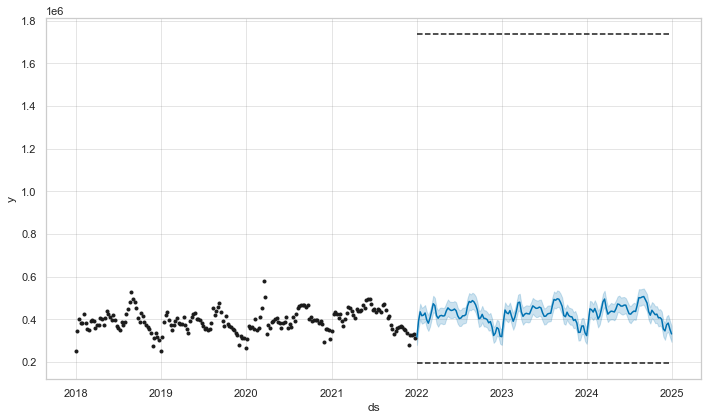

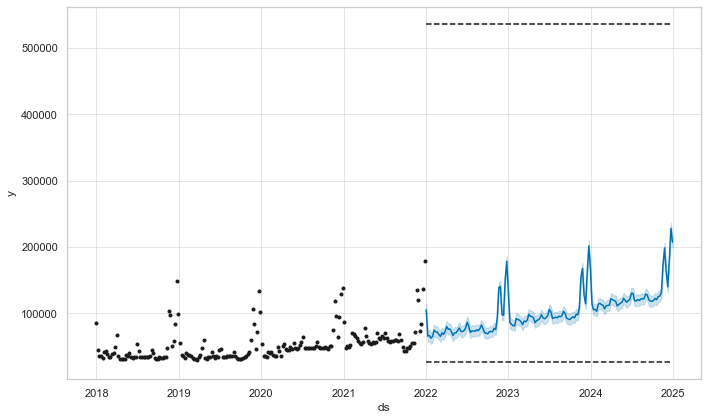

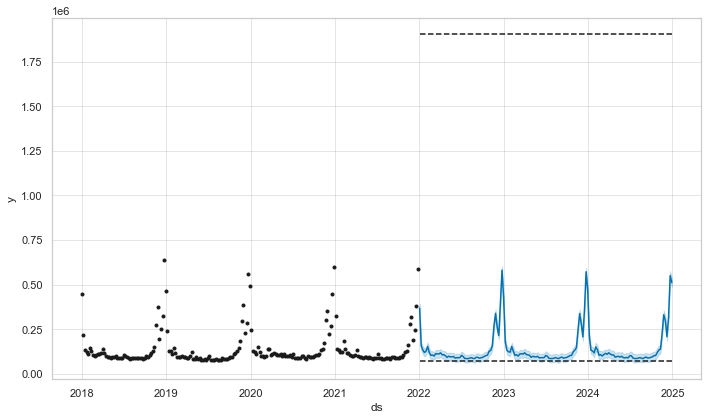

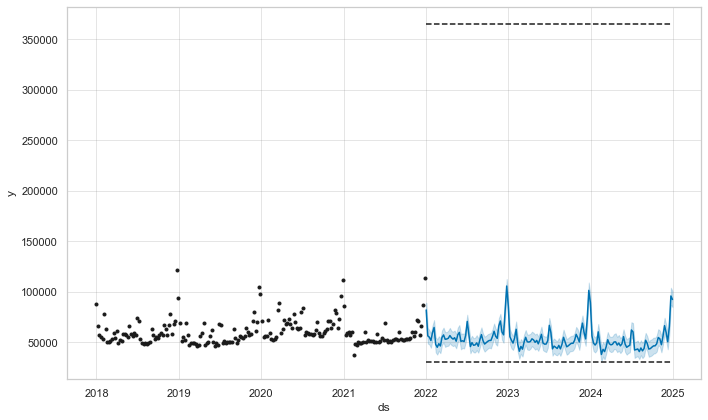

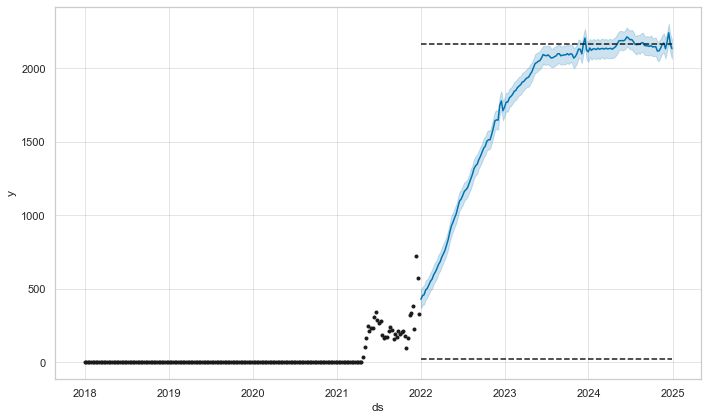

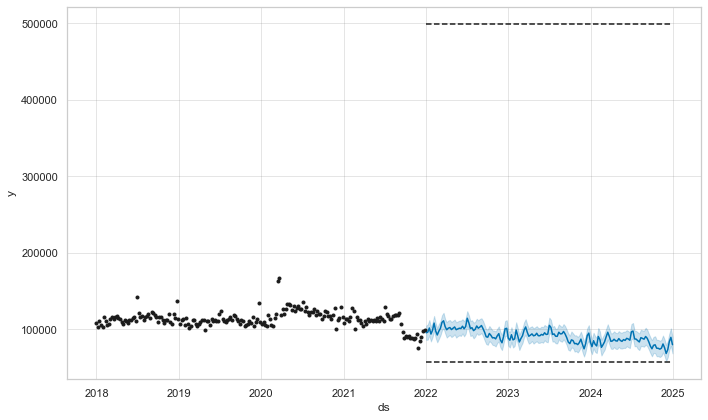

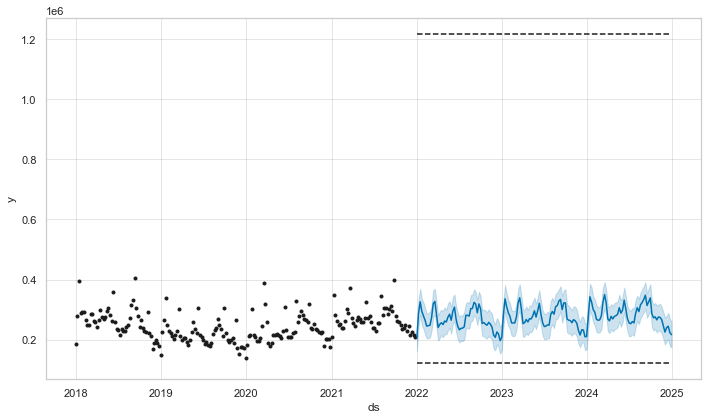

In [184]:
df_bel_brands = df_bel.groupby(["Date", "Brand"]).agg('sum')['Sales in volume'].unstack().reset_index()
df_bel_brands.columns.name=''
df_bel_brands = df_bel_brands.fillna(0)
df_bel_brands_fcst_res = forecasting_features(df_bel_brands, list(df_bel_brands.columns[1:]), periods=157, freq='W')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

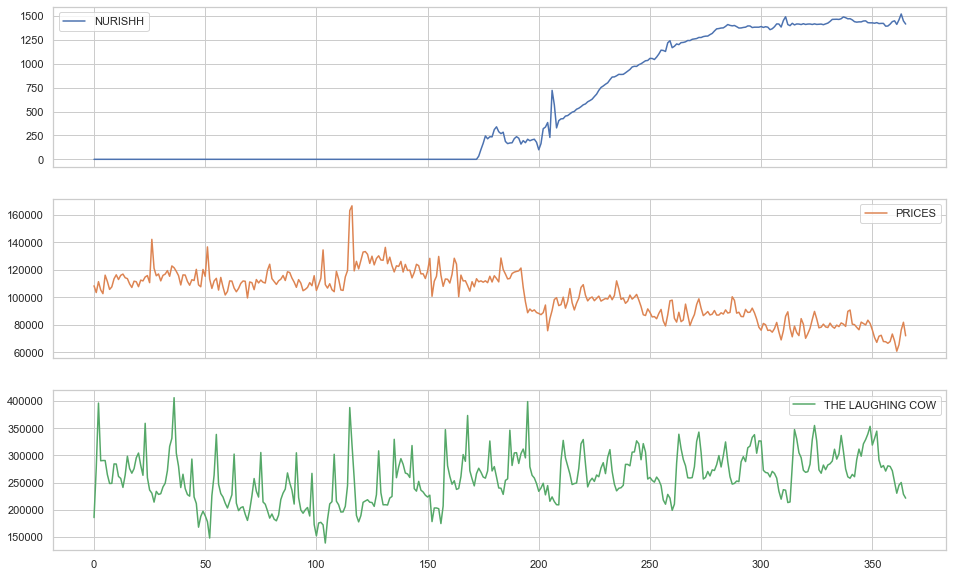

In [176]:
df_bel_brands_fcst_res.iloc[:, 5:].plot(subplots=True, figsize=(16, 10))

In [185]:
df_bel_brands_fcst_res['Date'] = df_bel_brands_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_bel_brands_fcst_res.round(1).to_excel("results/usa_brands_forecasts_no_regressors.xlsx", index=False)

### With Regressors

In [16]:
df_bel['Trends'] = df_bel.apply(lambda x: df_trends[df_trends.Date == x.Date][x.Brand].values[0], axis=1)
df_bel.fillna(0, inplace=True)
df_bel.head()

,Date,Brand,Price per volume,Sales in volume,Sales in value,Distribution,Sell-in,Advertising,Promotion,A&P,MVC,Rate of Innovation,Promo Cost,HH,Trends
0,2017-12-31,BABYBEL,11.307482,250446.559440,2.831920e+06,417.403475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
1,2017-12-31,BOURSIN,13.745852,85626.196096,1.177005e+06,152.674082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
2,2017-12-31,KAUKAUNA,6.703015,444672.382865,2.792992e+06,173.183200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43
3,2017-12-31,MERKTS,5.383924,88166.774383,4.746832e+05,77.224967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2017-12-31,PRICES,4.762444,108331.433158,5.159224e+05,93.366316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74


In [20]:
features_name = ['A&P', 'Price per volume', 'Promo Cost']
feats_futures, df_brands_fcst_res = forecasting_brands(df_bel, brands_name[country], features_name, periods=157, freq='W')

Brands:   0%|          | 0/7 [00:00<?, ?it/s]

Features:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.0312
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       288.231   9.37554e-06       65.0503           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       288.234   4.67123e-05       95.8891    4.67e-07       0.001      218  LS failed, Hessian reset 
     194       288.237   2.23762e-06       82.6199    2.31e-08       0.001      346  LS failed, Hessian reset 
     199       288.237   2.78041e-07       66.4512      0.7687      0.7687      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       288.237   2.95338e-08       73.4023      0.6277      0.6277      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.37415
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       601.815   0.000286759        75.928      0.5952      0.5952      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       602.671   9.02437e-07       67.6574         0.5         0.5      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       602.673   1.92844e-05       71.0745   2.246e-07       0.001      311  LS failed, Hessian reset 
     236       602.674   3.90086e-09       67.8943    0.007055      0.3595      354   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.267
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       315.377   2.06236e-05       77.0531           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       315.379   2.14799e-06       85.1797   3.193e-08       0.001      203  LS failed, Hessian reset 
     166       315.379   1.31592e-08       63.4359      0.9158      0.2293      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.6042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       509.343   1.49184e-05       82.4191      0.1647           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       509.355    7.7825e-05       90.8511    8.02e-07       0.001      192  LS failed, Hessian reset 
     148       509.358   3.54557e-08       58.5211           1           1      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Features:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -18.4194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       233.722   2.66698e-06       76.5496           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       233.723   6.63448e-06       71.1767   8.684e-08       0.001      189  LS failed, Hessian reset 
     129       233.723   4.98322e-09       69.2484      0.1309      0.1309      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.04965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.719   3.90185e-06       66.8501           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       485.731    2.1169e-06       71.6943    2.57e-08       0.001      243  LS failed, Hessian reset 
     177       485.731   1.66928e-08       76.6424      0.5388           1      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.1421
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       328.351   6.20727e-07       72.5491       1.169      0.2983      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       328.351   2.04415e-06       65.3587   2.123e-08       0.001      187  LS failed, Hessian reset 
     139       328.351   6.69627e-09       70.6978      0.5711      0.5711      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.88542
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       469.463   0.000139794       83.2349           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       469.473   2.83109e-05       74.8628   3.284e-07       0.001      242  LS failed, Hessian reset 
     169       469.475   1.46083e-08       67.0854      0.2828           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Features:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.29112
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       327.428   3.71796e-06       96.3903      0.3014      0.3014      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       327.431   4.10825e-06       87.6939    3.81e-08       0.001      251  LS failed, Hessian reset 
     189       327.431   8.24407e-09       93.2584      0.4572      0.4572      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.10879
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       566.463   4.11496e-05       89.7991      0.8974      0.8974      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       566.823   4.60122e-09       83.5015      0.0347      0.0347      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.95118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       271.537   6.46953e-05       90.8041   6.818e-07       0.001      109  LS failed, Hessian reset 
      92        271.54   6.41256e-09       80.4587       0.239           1      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3508
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.947   0.000762047       75.5233           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       502.214   0.000456502       100.282   4.557e-06       0.001      170  LS failed, Hessian reset 
     148       502.243   2.96213e-05       69.3473   3.212e-07       0.001      252  LS failed, Hessian reset 
     178       502.244   5.88509e-09       61.9553      0.1438      0.1438      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Features:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.2976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       264.079   1.23146e-07       86.8595       0.593       0.593      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       264.079   4.18995e-09       86.3583      0.3489      0.3489      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.02768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       594.226    0.00043473       79.0055           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162        594.99   0.000588952       194.768   5.859e-06       0.001      238  LS failed, Hessian reset 
     199       595.178   0.000205163         60.89      0.3299           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       595.388   0.000472192       133.446   3.893e-06       0.001      376  LS failed, Hessian reset 
     299       595.418   8.33576e-06        69.657     0.05284           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       595.547   0.000135429       65.2531   2.032e-06       0.001      556  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.95921
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       275.403   0.000823369       91.1459   8.859e-06       0.001      129  LS failed, Hessian reset 
      99       275.451   5.00977e-06       70.7566       0.487       0.487      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       275.631    0.00115122       97.1174   1.273e-05       0.001      330  LS failed, Hessian reset 
     199        275.89   5.68457e-05       75.3855           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       275.901   7.02998e-09       84.7052      0.2906      0.2906      499   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -41.9096
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       504.317    2.5599e-06       98.0407      0.3656      0.3656      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       504.353   9.13115e-05        93.703   1.121e-06       0.001      240  LS failed, Hessian reset 
     199       504.362   3.73217e-07       100.495           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       504.363   3.01475e-08       62.2361           1           1      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Features:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.5294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       226.356     0.0032875       104.681   3.192e-05       0.001      148  LS failed, Hessian reset 
      99       226.628   0.000217725       96.8027      0.6359      0.6359      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       226.662   8.81306e-06       92.9938   9.394e-08       0.001      271  LS failed, Hessian reset 
     168       226.663   1.56754e-06       104.423   1.493e-08       0.001      340  LS failed, Hessian reset 
     185       226.663   4.96309e-09        101.18      0.1313      0.1313      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.49045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       515.178    0.00139865       94.1794           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       515.871   8.97272e-05       56.3766   1.263e-06       0.001      238  LS failed, Hessian reset 
     181       516.114   0.000372589       63.1334   5.508e-06       0.001      330  LS failed, Hessian reset 
     199       516.133   4.06453e-05       60.1223           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       516.212   2.64898e-09       54.3151     0.05105     0.05105      469   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.62134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       387.229   0.000170643       64.8112   2.932e-06       0.001      127  LS failed, Hessian reset 
      99       387.268   0.000151386       46.5132           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       387.368   0.000325332       69.3473   4.404e-06       0.001      282  LS failed, Hessian reset 
     199       387.385   1.03916e-07       75.2786      0.3649      0.3649      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       387.397   4.72958e-06       66.4283     0.09729           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       387.427   4.78738e-05       65.9551   1.136e-06       0.001      554  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -14.9121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       486.461   8.49326e-07       68.5601       1.835       0.554      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138        486.88   0.000643073       91.1231    7.04e-06       0.001      231  LS failed, Hessian reset 
     199       487.009   1.30653e-06       78.1622     0.09793     0.09793      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233        487.01   3.94608e-09       58.6836      0.1084      0.1084      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Features:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.60429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       257.115   7.63724e-06       94.5512      0.5475      0.5475      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       257.118    5.3518e-09       81.6641       0.322       0.322      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.51538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.142    0.00106546       85.9374      0.1913           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       506.808    0.00130875       135.945   2.093e-05       0.001      236  LS failed, Hessian reset 
     199       506.902    0.00035991       64.8447       0.381           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       506.924   0.000286241       52.9246   3.939e-06       0.001      362  LS failed, Hessian reset 
     240        506.94   1.73322e-08       56.1887      0.2128           1      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.6376
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       314.418    0.00044381       55.3003           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       314.545   0.000839025       68.7295   1.221e-05       0.001      191  LS failed, Hessian reset 
     159       314.736   0.000105684       81.0758   1.618e-06       0.001      307  LS failed, Hessian reset 
     193       314.739   3.39043e-07        73.012   5.337e-09       0.001      392  LS failed, Hessian reset 
     199       314.739   2.15221e-08       58.2513      0.3891           1      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       314.739   8.14714e-09       54.1315      0.3569      0.3569      403   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.80679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       537.553   1.22671e-06       60.7357      0.2707           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       537.968   0.000353949       84.2237   4.348e-06       0.001      282  LS failed, Hessian reset 
     199       537.981    2.2569e-06       66.4165      0.9989      0.9989      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       537.982   1.10561e-05       74.7523     1.6e-07       0.001      367  LS failed, Hessian reset 
     219       537.983   3.12437e-07       61.7016   5.087e-09       0.001      414  LS failed, Hessian reset 
     239       537.983   8.31056e-09       73.3344     0.04303           1      443   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

Features:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = 10.4301
Iteration  1. Log joint probability =   0.555803. Improved by -9.8743.
Iteration  2. Log joint probability =    29.2949. Improved by 28.7391.
Iteration  3. Log joint probability =    31.3788. Improved by 2.08384.
Iteration  4. Log joint probability =    31.6907. Improved by 0.311902.
Iteration  5. Log joint probability =    31.7146. Improved by 0.023986.
Iteration  6. Log joint probability =     31.715. Improved by 0.000386409.
Iteration  7. Log joint probability =    31.7248. Improved by 0.00980728.
Iteration  8. Log joint probability =     31.776. Improved by 0.0511938.
Iteration  9. Log joint probability =    31.8912. Improved by 0.115149.
Iteration 10. Log joint probability =    31.9056. Improved by 0.0144233.
Iteration 11. Log joint probability =    31.9404. Improved by 0.0348301.
Iteration 12. Log joint probability =    32.0188. Improved by 0.0783766.
Iteration 13. Log joint probability =    32.0489. Improved by 0.0300366.
Iteration 14. Lo

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_


Initial log joint probability = 16.1176
Iteration  1. Log joint probability =    39.7725. Improved by 23.655.
Iteration  2. Log joint probability =    63.9027. Improved by 24.1302.
Iteration  3. Log joint probability =    75.1857. Improved by 11.2829.
Iteration  4. Log joint probability =      78.31. Improved by 3.1243.
Iteration  5. Log joint probability =    78.8559. Improved by 0.545928.
Iteration  6. Log joint probability =    78.8592. Improved by 0.00328098.
Iteration  7. Log joint probability =    78.8682. Improved by 0.00904751.
Iteration  8. Log joint probability =     78.895. Improved by 0.0267504.
Iteration  9. Log joint probability =    78.9053. Improved by 0.0103676.
Iteration 10. Log joint probability =     78.918. Improved by 0.0126999.
Iteration 11. Log joint probability =     78.941. Improved by 0.0230093.
Iteration 12. Log joint probability =    79.2538. Improved by 0.312764.
Iteration 13. Log joint probability =    79.4264. Improved by 0.172612.
Iteration 14. Log joi

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_


Initial log joint probability = 14.6958
Iteration  1. Log joint probability =    22.4593. Improved by 7.76357.
Iteration  2. Log joint probability =    29.3475. Improved by 6.8882.
Iteration  3. Log joint probability =    30.9276. Improved by 1.58005.
Iteration  4. Log joint probability =    31.6064. Improved by 0.678796.
Iteration  5. Log joint probability =    31.6687. Improved by 0.0622994.
Iteration  6. Log joint probability =    31.6943. Improved by 0.0255975.
Iteration  7. Log joint probability =    31.7448. Improved by 0.0505339.
Iteration  8. Log joint probability =    31.7682. Improved by 0.0234243.
Iteration  9. Log joint probability =    31.8932. Improved by 0.124913.
Iteration 10. Log joint probability =    31.9618. Improved by 0.0686462.
Iteration 11. Log joint probability =    31.9646. Improved by 0.0027881.
Iteration 12. Log joint probability =    32.0402. Improved by 0.0756547.
Iteration 13. Log joint probability =    32.1527. Improved by 0.112458.
Iteration 14. Log jo

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = 6.94173
Iteration  1. Log joint probability =      31.73. Improved by 24.7883.
Iteration  2. Log joint probability =    48.9143. Improved by 17.1843.
Iteration  3. Log joint probability =    54.2683. Improved by 5.35406.
Iteration  4. Log joint probability =    54.6926. Improved by 0.424309.
Iteration  5. Log joint probability =    54.8256. Improved by 0.132961.
Iteration  6. Log joint probability =    54.8546. Improved by 0.0289578.
Iteration  7. Log joint probability =    54.8655. Improved by 0.0109382.
Iteration  8. Log joint probability =    54.8775. Improved by 0.0119506.
Iteration  9. Log joint probability =    54.8845. Improved by 0.00701932.
Iteration 10. Log joint probability =    54.8946. Improved by 0.0101731.
Iteration 11. Log joint probability =    54.8951. Improved by 0.000494361.
Iteration 12. Log joint probability =     54.901. Improved by 0.00585422.
Iteration 13. Log joint probability =    54.9034. Improved by 0.00242519.
Iteration 14.

In [242]:
pd.DataFrame(np.zeros((10, 10))) + pd.DataFrame(np.ones((5, 5)))

,0,1,2,3,4,5,6,7,8,9
0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
import numpy as np
tmp = (pd.DataFrame(np.zeros((10, 10))) + pd.DataFrame(np.ones((5, 5))))
tmp.update(pd.DataFrame(np.zeros((10, 10))))
tmp


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_brands_fcst_res.fillna(0, inplace=True)
df_brands_fcst_res['Date'] = df_brands_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_brands_fcst_res.round(1).to_excel("results/usa_brands_forecasts_with_regressors.xlsx", index=False)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

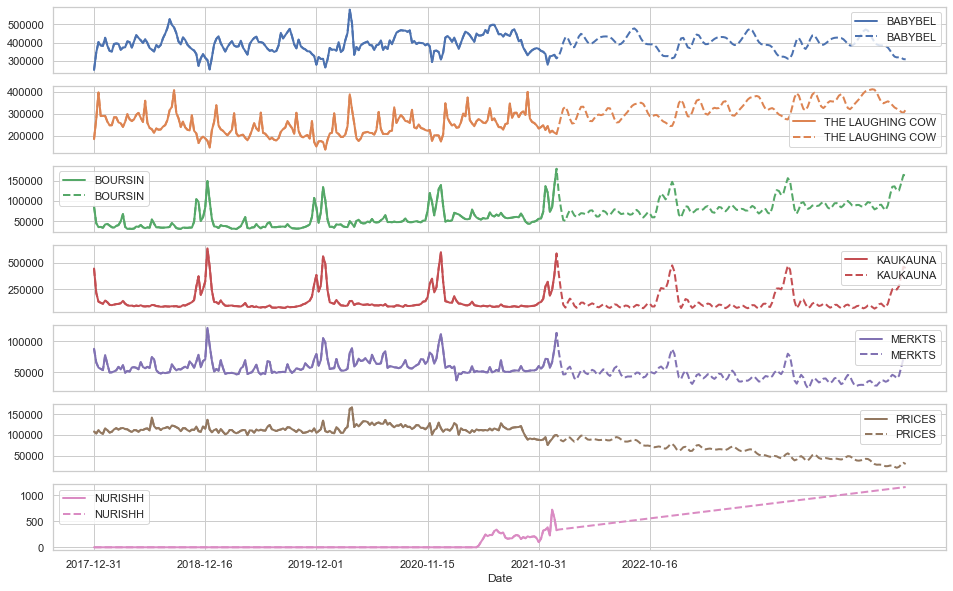

In [121]:
ax = df_brands_fcst_res.set_index("Date").loc['2017-12-31':'2021-12-26'].plot(linewidth=2, subplots=True, figsize=(16, 10))
df_brands_fcst_res.set_index("Date").plot(linewidth=2, linestyle='--', subplots=True, figsize=(16, 10), ax=ax)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>], dtype=object)

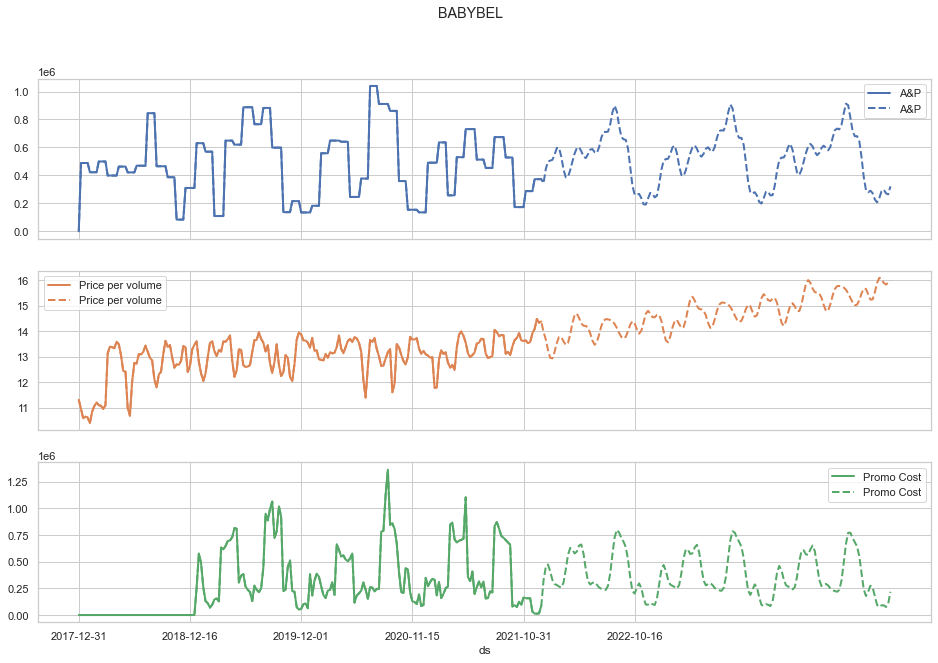

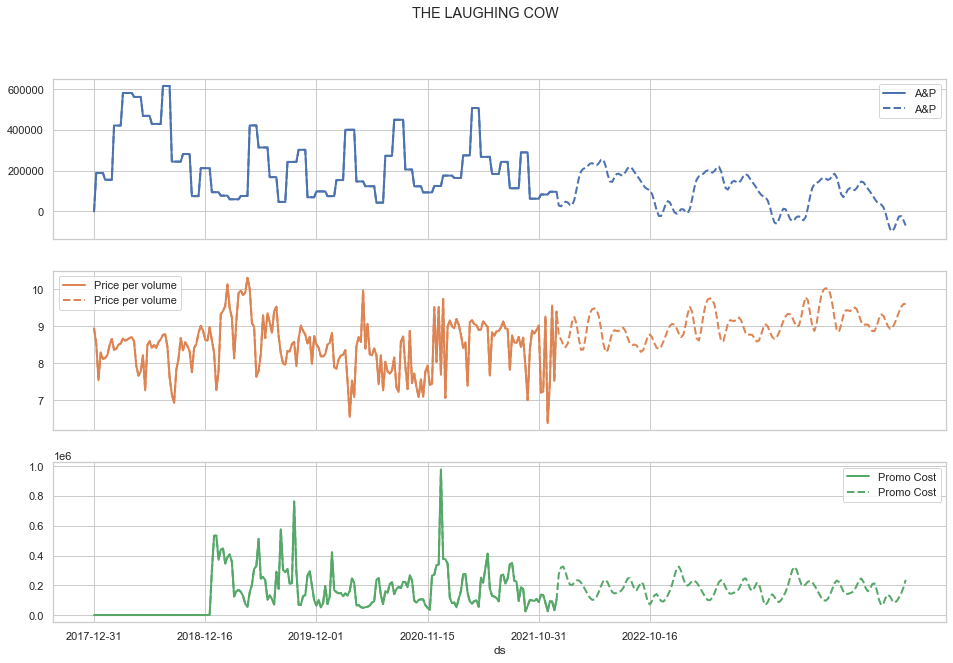

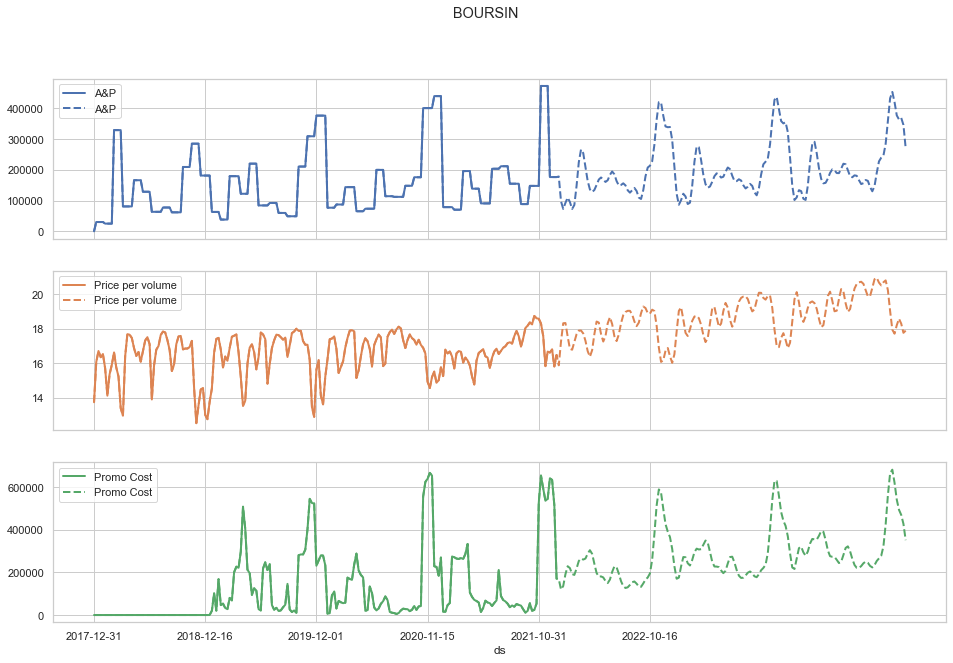

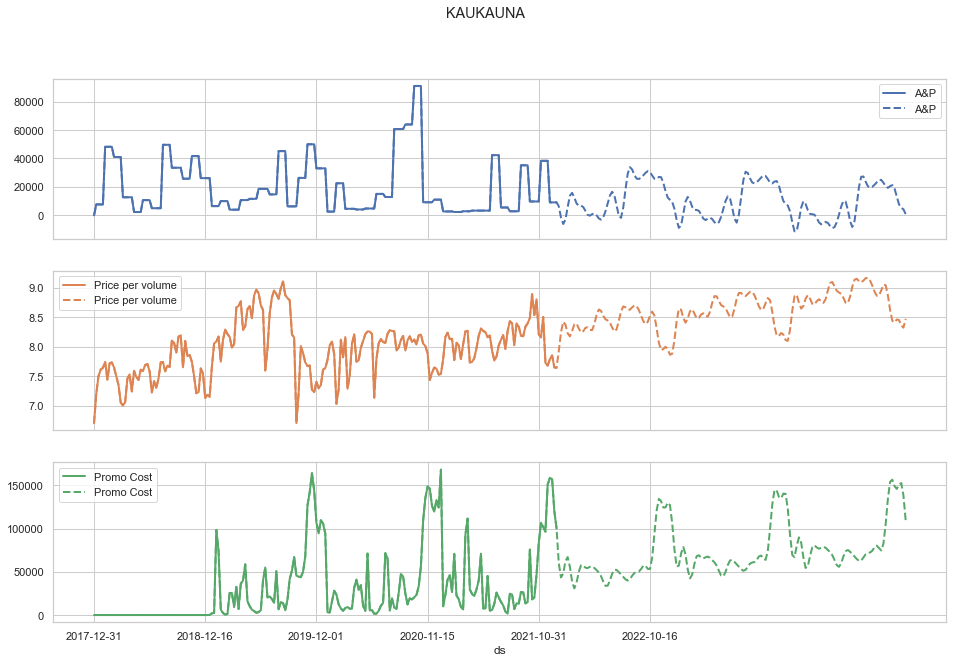

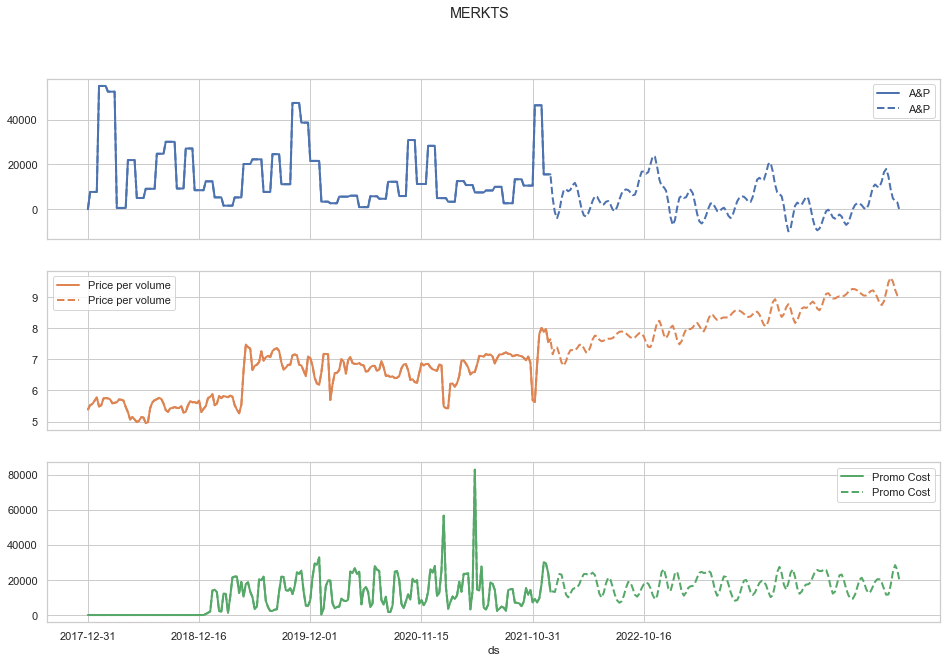

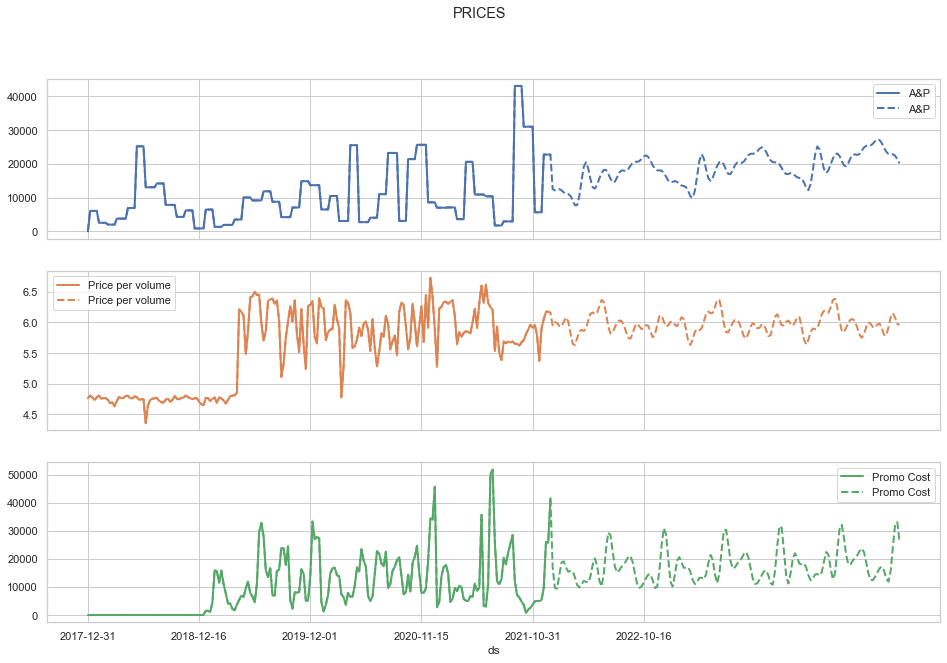

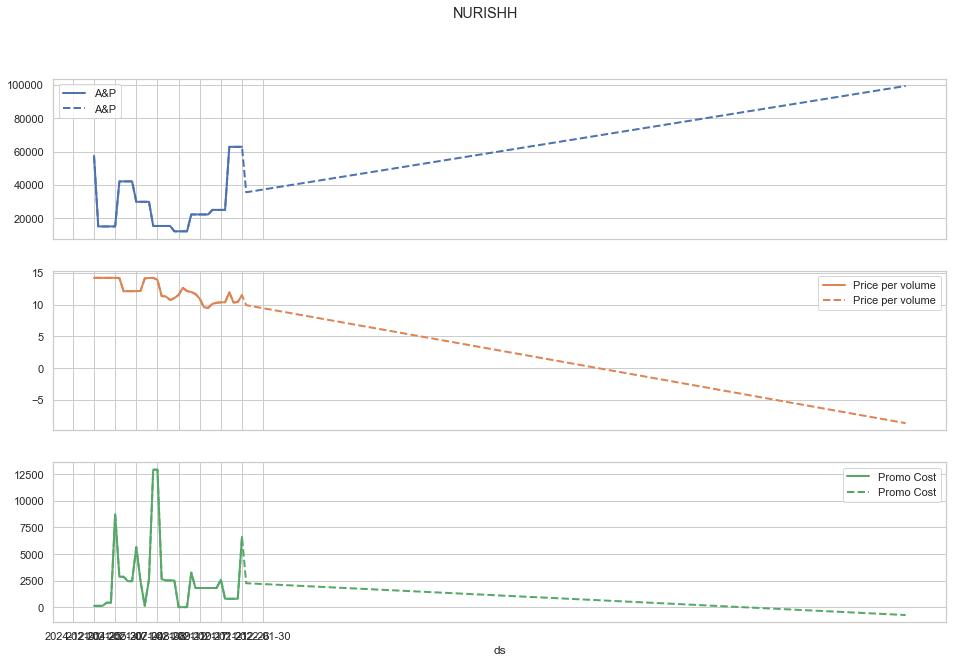

In [123]:
for brand in feats_futures:
    ax = feats_futures[brand].set_index('ds').loc['2017-12-31':'2021-12-26'].plot(subplots=True, figsize=(16, 10), title=brand, linewidth=2);
    feats_futures[brand].set_index('ds').plot(
        subplots=True, figsize=(16, 10), title=brand, 
        linestyle='--', linewidth=2, ax=ax);

## Forecasting Markets

In [59]:
df_gourmet = df[df.Category ==  "GOURMET"].groupby(["Date", "Sub Category"]).agg('sum')['Sales in volume'].unstack().reset_index()
df_gourmet.columns.name=''
df_gourmet_fcst_res = forecasting_markets(df_gourmet, list(df_gourmet.columns[1:]), periods=157, freq='W')

,Date,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS
0,2017-12-31,910386.230086,818842.263231,1.453368e+06,154547.998941,815257.286237
1,2018-01-07,627556.294548,858391.187412,1.167111e+06,144255.653824,456800.992770
2,2018-01-14,539699.852572,894206.079092,1.055935e+06,143657.117810,332330.501582
3,2018-01-21,529988.231607,879849.484174,1.045914e+06,149331.349177,316654.539204
4,2018-01-28,513346.849893,858912.224229,1.055987e+06,137646.808711,320892.632563


Features:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -18.2424
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       515.651   0.000485701       105.251      0.6357      0.6357      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112        515.87   0.000564092       77.7035   6.154e-06       0.001      181  LS failed, Hessian reset 
     183       515.936   1.17294e-06       86.0646   1.347e-08       0.001      314  LS failed, Hessian reset 
     199       515.936   3.21382e-08       71.7737           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       515.936   9.14944e-09       78.1974      0.2828      0.2828      343   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.6612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63         542.3   0.000671095       59.5595   1.097e-05       0.001      120  LS failed, Hessian reset 
      88       542.721    0.00429101       148.744   6.158e-05       0.001      186  LS failed, Hessian reset 
      99       542.859   0.000112803       68.5414           1           1      206   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       543.441   0.000433832       59.0196      0.2178           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       543.465   0.000154511        67.611   1.818e-06       0.001      401  LS failed, Hessian reset 
     244        543.47   4.50607e-06       69.1549   7.616e-08       0.001      468  LS failed, Hessian reset 
     299       543.474   6.84479e-05       72.4047           1    

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.06316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       451.876    0.00149321       134.646   1.658e-05       0.001      108  LS failed, Hessian reset 
      88       451.987   0.000126681       81.2974   1.513e-06       0.001      177  LS failed, Hessian reset 
      99       451.995   1.15043e-05        71.302       1.193      0.3732      193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       451.996   2.98223e-09       62.8705     0.05454     0.05454      247   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.05448
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       538.711   2.26446e-05       63.1813       0.242       0.242      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127        538.88   0.000288279        77.279    4.17e-06       0.001      214  LS failed, Hessian reset 
     166       538.977   0.000366667        79.927    4.36e-06       0.001      297  LS failed, Hessian reset 
     199       539.003   7.74126e-06       70.4839      0.4171           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       539.003   1.12748e-08       62.7677      0.2687           1      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -32.7609
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.341   1.47592e-05       80.1319      0.4618      0.4618      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       506.344   1.92322e-05       88.9148   2.623e-07       0.001      198  LS failed, Hessian reset 
     148       506.345   1.39068e-08       76.9412      0.4765      0.4765      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_gourmet_fcst_res.tail()

In [189]:
features_markets = list(df.Category.unique()) + ['TOTAL CHEESE']
df_markets = get_df_markets(df)
df_markets.head()

,Date,CLASSIC SPREADS,CREAM CHEESE,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,PLANT BASED,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS,TOTAL CHEESE
0,2017-12-31,556099.935784,1.033235e+07,1.502459e+06,1.672481e+07,2.591275e+07,899559.934396,801052.378777,1.430267e+06,154547.998941,807221.657009,450073.275428,182981.446283,2.945739e+06,1.208037e+07,4.945789e+06,2.172508e+06,8.189857e+07
1,2018-01-07,390664.450959,7.519594e+06,8.878940e+05,1.453252e+07,2.628333e+07,619468.304908,844736.884993,1.146266e+06,144260.559694,450767.240308,458259.684991,196951.775652,2.100265e+06,1.397689e+07,6.439323e+06,3.459148e+06,7.945034e+07
2,2018-01-14,358948.174883,6.665960e+06,4.492479e+05,1.322535e+07,2.533961e+07,531928.485964,879634.905349,1.034399e+06,143662.079434,325780.725853,502895.706163,205332.246870,2.013697e+06,1.480020e+07,7.008360e+06,3.769736e+06,7.725474e+07
3,2018-01-21,344453.590714,6.555467e+06,4.660944e+05,1.268997e+07,2.471744e+07,521978.033942,864079.716163,1.021411e+06,149351.267530,312998.041373,451407.992958,196801.380501,1.984600e+06,1.403472e+07,6.541865e+06,3.674175e+06,7.452682e+07
4,2018-01-28,337169.132159,6.568254e+06,4.606846e+05,1.177196e+07,2.334294e+07,505710.471442,844956.077292,1.034156e+06,137656.835024,314342.702673,443363.429657,191555.917983,1.896823e+06,1.291319e+07,6.394770e+06,3.487291e+06,7.064482e+07


In [217]:
features_markets

['CLASSIC SPREADS',
 'CREAM CHEESE',
 'ENTERTAINING TRAYS',
 'EVERYDAY BLOCKS',
 'EVERYDAY SHREDDED & GRATED',
 'GOURMET BLOCK / WEDGE / ROUND',
 'GOURMET CRUMBLED',
 'GOURMET FRESH ITALIAN',
 'GOURMET SHREDDED / GRATED',
 'GOURMET SPREADS',
 'PIMENTO',
 'RICOTTA AND FARMERS',
 'SLICES',
 'SNACK',
 'SNACKING COMBOS',
 'PLANT BASED',
 'TOTAL CHEESE']

Features:   0%|          | 0/17 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -20.6196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       516.483    6.5136e-05       72.8176   1.125e-06       0.001      115  LS failed, Hessian reset 
      99       516.496   5.59778e-06       84.2882      0.3759           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       516.914     0.0016162       83.0562   2.009e-05       0.001      268  LS failed, Hessian reset 
     199       517.169   5.04544e-08       54.3618     0.08649     0.08649      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       517.648    0.00327701       72.9066   6.274e-05       0.001      547  LS failed, Hessian reset 
     299       517.746   0.000584214       81.0164           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend           cap          floor     yhat_lower  \
0   2022-01-02  401032.652387  2.491356e+06  195886.441563  503177.183722   
1   2022-01-09  401019.871095  2.491356e+06  195886.441563  344248.043168   
2   2022-01-16  401007.090522  2.491356e+06  195886.441563  338388.396354   
3   2022-01-23  400994.310666  2.491356e+06  195886.441563  320228.535547   
4   2022-01-30  400981.531528  2.491356e+06  195886.441563  366526.913129   
..         ...            ...           ...            ...            ...   
152 2024-12-01  399098.120215  2.491356e+06  195886.441563  459593.452105   
153 2024-12-08  399085.447734  2.491356e+06  195886.441563  372579.424464   
154 2024-12-15  399072.775967  2.491356e+06  195886.441563  486961.017265   
155 2024-12-22  399060.104913  2.491356e+06  195886.441563  674330.445680   
156 2024-12-29  399047.434573  2.491356e+06  195886.441563  618933.556875   

        yhat_upper    trend_lower    trend_upper  additive_t

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap         floor    yhat_lower  \
0   2022-01-02  9.494062e+06  5.577973e+07  4.265968e+06  1.063900e+07   
1   2022-01-09  9.502076e+06  5.577973e+07  4.265968e+06  7.385049e+06   
2   2022-01-16  9.510100e+06  5.577973e+07  4.265968e+06  7.770247e+06   
3   2022-01-23  9.518136e+06  5.577973e+07  4.265968e+06  7.228839e+06   
4   2022-01-30  9.526183e+06  5.577973e+07  4.265968e+06  8.060198e+06   
..         ...           ...           ...           ...           ...   
152 2024-12-01  1.084311e+07  5.577973e+07  4.265968e+06  1.417068e+07   
153 2024-12-08  1.085290e+07  5.577973e+07  4.265968e+06  9.407873e+06   
154 2024-12-15  1.086270e+07  5.577973e+07  4.265968e+06  1.312174e+07   
155 2024-12-22  1.087251e+07  5.577973e+07  4.265968e+06  1.791455e+07   
156 2024-12-29  1.088234e+07  5.577973e+07  4.265968e+06  1.544980e+07   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    1.287599e+07  9.494062e+06

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap          floor    yhat_lower  \
0   2022-01-02  1.021091e+06  1.028983e+07  402340.998335  1.950872e+06   
1   2022-01-09  1.023876e+06  1.028983e+07  402340.998335  8.875245e+05   
2   2022-01-16  1.026674e+06  1.028983e+07  402340.998335  7.136751e+05   
3   2022-01-23  1.029483e+06  1.028983e+07  402340.998335  7.242089e+05   
4   2022-01-30  1.032304e+06  1.028983e+07  402340.998335  8.147226e+05   
..         ...           ...           ...            ...           ...   
152 2024-12-01  1.603746e+06  1.028983e+07  402340.998335  1.951125e+06   
153 2024-12-08  1.608813e+06  1.028983e+07  402340.998335  1.454091e+06   
154 2024-12-15  1.613899e+06  1.028983e+07  402340.998335  1.860941e+06   
155 2024-12-22  1.619003e+06  1.028983e+07  402340.998335  2.957904e+06   
156 2024-12-29  1.624126e+06  1.028983e+07  402340.998335  3.081136e+06   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    2.268643e+06  

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap         floor    yhat_lower  \
0   2022-01-02  1.350185e+07  6.736440e+07  6.573768e+06  1.531496e+07   
1   2022-01-09  1.350331e+07  6.736440e+07  6.573768e+06  1.209350e+07   
2   2022-01-16  1.350477e+07  6.736440e+07  6.573768e+06  1.215187e+07   
3   2022-01-23  1.350622e+07  6.736440e+07  6.573768e+06  1.146404e+07   
4   2022-01-30  1.350768e+07  6.736440e+07  6.573768e+06  1.238843e+07   
..         ...           ...           ...           ...           ...   
152 2024-12-01  1.372650e+07  6.736440e+07  6.573768e+06  1.523354e+07   
153 2024-12-08  1.372800e+07  6.736440e+07  6.573768e+06  1.113797e+07   
154 2024-12-15  1.372950e+07  6.736440e+07  6.573768e+06  1.368283e+07   
155 2024-12-22  1.373100e+07  6.736440e+07  6.573768e+06  1.844240e+07   
156 2024-12-29  1.373250e+07  6.736440e+07  6.573768e+06  1.788816e+07   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    1.844793e+07  1.350185e+07

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap         floor    yhat_lower  \
0   2022-01-02  2.896205e+07  1.206387e+08  1.338361e+07  2.923968e+07   
1   2022-01-09  2.896570e+07  1.206387e+08  1.338361e+07  2.696607e+07   
2   2022-01-16  2.896935e+07  1.206387e+08  1.338361e+07  2.837703e+07   
3   2022-01-23  2.897301e+07  1.206387e+08  1.338361e+07  2.666206e+07   
4   2022-01-30  2.897666e+07  1.206387e+08  1.338361e+07  2.755996e+07   
..         ...           ...           ...           ...           ...   
152 2024-12-01  2.952541e+07  1.206387e+08  1.338361e+07  2.774142e+07   
153 2024-12-08  2.952917e+07  1.206387e+08  1.338361e+07  2.466515e+07   
154 2024-12-15  2.953293e+07  1.206387e+08  1.338361e+07  2.857577e+07   
155 2024-12-22  2.953669e+07  1.206387e+08  1.338361e+07  3.383863e+07   
156 2024-12-29  2.954046e+07  1.206387e+08  1.338361e+07  3.231018e+07   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    3.413160e+07  2.896205e+07

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap          floor    yhat_lower  \
0   2022-01-02  9.418371e+05  6.053555e+06  355225.560124  1.205548e+06   
1   2022-01-09  9.448628e+05  6.053555e+06  355225.560124  8.112522e+05   
2   2022-01-16  9.479023e+05  6.053555e+06  355225.560124  8.374452e+05   
3   2022-01-23  9.509556e+05  6.053555e+06  355225.560124  8.161763e+05   
4   2022-01-30  9.540229e+05  6.053555e+06  355225.560124  8.106731e+05   
..         ...           ...           ...            ...           ...   
152 2024-12-01  1.582390e+06  6.053555e+06  355225.560124  1.789490e+06   
153 2024-12-08  1.587923e+06  6.053555e+06  355225.560124  1.449578e+06   
154 2024-12-15  1.593474e+06  6.053555e+06  355225.560124  1.739538e+06   
155 2024-12-22  1.599043e+06  6.053555e+06  355225.560124  2.284370e+06   
156 2024-12-29  1.604630e+06  6.053555e+06  355225.560124  2.169952e+06   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    1.368194e+06  

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap          floor    yhat_lower  \
0   2022-01-02  1.222810e+06  4.568345e+06  516875.899683  1.087610e+06   
1   2022-01-09  1.224367e+06  4.568345e+06  516875.899683  1.103519e+06   
2   2022-01-16  1.225928e+06  4.568345e+06  516875.899683  1.149769e+06   
3   2022-01-23  1.227490e+06  4.568345e+06  516875.899683  1.093111e+06   
4   2022-01-30  1.229056e+06  4.568345e+06  516875.899683  1.119376e+06   
..         ...           ...           ...            ...           ...   
152 2024-12-01  1.491110e+06  4.568345e+06  516875.899683  1.205041e+06   
153 2024-12-08  1.493087e+06  4.568345e+06  516875.899683  1.189826e+06   
154 2024-12-15  1.495066e+06  4.568345e+06  516875.899683  1.269307e+06   
155 2024-12-22  1.497048e+06  4.568345e+06  516875.899683  1.385065e+06   
156 2024-12-29  1.499033e+06  4.568345e+06  516875.899683  1.387493e+06   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    1.258021e+06  

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap          floor    yhat_lower  \
0   2022-01-02  1.477385e+06  6.889737e+06  692644.177227  1.446102e+06   
1   2022-01-09  1.477629e+06  6.889737e+06  692644.177227  1.032476e+06   
2   2022-01-16  1.477874e+06  6.889737e+06  692644.177227  1.088430e+06   
3   2022-01-23  1.478118e+06  6.889737e+06  692644.177227  1.049102e+06   
4   2022-01-30  1.478363e+06  6.889737e+06  692644.177227  1.127344e+06   
..         ...           ...           ...            ...           ...   
152 2024-12-01  1.515268e+06  6.889737e+06  692644.177227  1.187353e+06   
153 2024-12-08  1.515523e+06  6.889737e+06  692644.177227  1.074380e+06   
154 2024-12-15  1.515777e+06  6.889737e+06  692644.177227  1.418037e+06   
155 2024-12-22  1.516031e+06  6.889737e+06  692644.177227  1.869255e+06   
156 2024-12-29  1.516286e+06  6.889737e+06  692644.177227  1.768305e+06   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    1.788783e+06  

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend           cap          floor     yhat_lower  \
0   2022-01-02  306779.437341  1.387447e+06  113684.889451  305313.532925   
1   2022-01-09  307350.424187  1.387447e+06  113684.889451  276854.945309   
2   2022-01-16  307922.795984  1.387447e+06  113684.889451  301107.595887   
3   2022-01-23  308496.554296  1.387447e+06  113684.889451  284688.637520   
4   2022-01-30  309071.700679  1.387447e+06  113684.889451  282739.855910   
..         ...            ...           ...            ...            ...   
152 2024-12-01  410114.782603  1.387447e+06  113684.889451  367796.255310   
153 2024-12-08  410907.293832  1.387447e+06  113684.889451  338634.030013   
154 2024-12-15  411701.277775  1.387447e+06  113684.889451  378018.972862   
155 2024-12-22  412496.733717  1.387447e+06  113684.889451  450737.740005   
156 2024-12-29  413293.660921  1.387447e+06  113684.889451  427004.875324   

        yhat_upper    trend_lower    trend_upper  additive_t

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend           cap          floor    yhat_lower  \
0   2022-01-02  420599.013504  3.701900e+06  190628.829243  7.241174e+05   
1   2022-01-09  421027.436947  3.701900e+06  190628.829243  3.742902e+05   
2   2022-01-16  421456.602376  3.701900e+06  190628.829243  3.484944e+05   
3   2022-01-23  421886.510868  3.701900e+06  190628.829243  3.288453e+05   
4   2022-01-30  422317.163499  3.701900e+06  190628.829243  3.502876e+05   
..         ...            ...           ...            ...           ...   
152 2024-12-01  494866.310433  3.701900e+06  190628.829243  6.820398e+05   
153 2024-12-08  495420.238730  3.701900e+06  190628.829243  5.014302e+05   
154 2024-12-15  495975.079546  3.701900e+06  190628.829243  7.082408e+05   
155 2024-12-22  496530.834033  3.701900e+06  190628.829243  1.113092e+06   
156 2024-12-29  497087.503345  3.701900e+06  190628.829243  1.035130e+06   

       yhat_upper    trend_lower    trend_upper  additive_terms  \
0    

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend           cap          floor     yhat_lower  \
0   2022-01-02  498985.039795  2.288965e+06  264884.302847  412550.578393   
1   2022-01-09  498327.095846  2.288965e+06  264884.302847  423841.180830   
2   2022-01-16  497670.760576  2.288965e+06  264884.302847  461725.123792   
3   2022-01-23  497016.031403  2.288965e+06  264884.302847  416748.483014   
4   2022-01-30  496362.905741  2.288965e+06  264884.302847  427907.469341   
..         ...            ...           ...            ...            ...   
152 2024-12-01  415911.046130  2.288965e+06  264884.302847  331175.085144   
153 2024-12-08  415466.941348  2.288965e+06  264884.302847  349196.492212   
154 2024-12-15  415024.037808  2.288965e+06  264884.302847  402709.018882   
155 2024-12-22  414582.332876  2.288965e+06  264884.302847  434994.539681   
156 2024-12-29  414141.823919  2.288965e+06  264884.302847  367010.042090   

        yhat_upper    trend_lower    trend_upper  additive_t

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap         floor    yhat_lower  \
0   2022-01-02  2.192019e+06  1.587704e+07  1.012630e+06  2.766649e+06   
1   2022-01-09  2.193513e+06  1.587704e+07  1.012630e+06  1.636127e+06   
2   2022-01-16  2.195009e+06  1.587704e+07  1.012630e+06  2.024534e+06   
3   2022-01-23  2.196507e+06  1.587704e+07  1.012630e+06  1.875048e+06   
4   2022-01-30  2.198007e+06  1.587704e+07  1.012630e+06  1.868336e+06   
..         ...           ...           ...           ...           ...   
152 2024-12-01  2.439943e+06  1.587704e+07  1.012630e+06  2.347623e+06   
153 2024-12-08  2.441719e+06  1.587704e+07  1.012630e+06  2.021174e+06   
154 2024-12-15  2.443496e+06  1.587704e+07  1.012630e+06  2.924147e+06   
155 2024-12-22  2.445276e+06  1.587704e+07  1.012630e+06  4.622299e+06   
156 2024-12-29  2.447058e+06  1.587704e+07  1.012630e+06  4.128909e+06   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    3.398895e+06  2.192019e+06

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap         floor    yhat_lower  \
0   2022-01-02  1.578029e+07  6.968136e+07  7.414669e+06  1.306542e+07   
1   2022-01-09  1.578676e+07  6.968136e+07  7.414669e+06  1.458009e+07   
2   2022-01-16  1.579323e+07  6.968136e+07  7.414669e+06  1.526381e+07   
3   2022-01-23  1.579971e+07  6.968136e+07  7.414669e+06  1.390956e+07   
4   2022-01-30  1.580619e+07  6.968136e+07  7.414669e+06  1.391223e+07   
..         ...           ...           ...           ...           ...   
152 2024-12-01  1.681258e+07  6.968136e+07  7.414669e+06  1.314877e+07   
153 2024-12-08  1.681971e+07  6.968136e+07  7.414669e+06  1.455635e+07   
154 2024-12-15  1.682684e+07  6.968136e+07  7.414669e+06  1.500225e+07   
155 2024-12-22  1.683397e+07  6.968136e+07  7.414669e+06  1.431215e+07   
156 2024-12-29  1.684111e+07  6.968136e+07  7.414669e+06  1.384825e+07   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    1.549994e+07  1.578029e+07

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap         floor    yhat_lower  \
0   2022-01-02  7.230298e+06  3.090333e+07  3.403428e+06  5.883158e+06   
1   2022-01-09  7.234497e+06  3.090333e+07  3.403428e+06  7.082547e+06   
2   2022-01-16  7.238699e+06  3.090333e+07  3.403428e+06  7.481035e+06   
3   2022-01-23  7.242906e+06  3.090333e+07  3.403428e+06  6.891597e+06   
4   2022-01-30  7.247116e+06  3.090333e+07  3.403428e+06  6.914274e+06   
..         ...           ...           ...           ...           ...   
152 2024-12-01  7.913813e+06  3.090333e+07  3.403428e+06  6.466406e+06   
153 2024-12-08  7.918618e+06  3.090333e+07  3.403428e+06  7.010680e+06   
154 2024-12-15  7.923428e+06  3.090333e+07  3.403428e+06  7.264179e+06   
155 2024-12-22  7.928241e+06  3.090333e+07  3.403428e+06  6.749611e+06   
156 2024-12-29  7.933059e+06  3.090333e+07  3.403428e+06  6.315444e+06   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    6.707553e+06  7.230298e+06

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds         trend           cap         floor    yhat_lower  \
0   2022-01-02  4.319144e+06  1.677065e+07  2.054190e+06  2.904749e+06   
1   2022-01-09  4.321123e+06  1.677065e+07  2.054190e+06  3.931808e+06   
2   2022-01-16  4.323104e+06  1.677065e+07  2.054190e+06  4.485102e+06   
3   2022-01-23  4.325086e+06  1.677065e+07  2.054190e+06  4.050931e+06   
4   2022-01-30  4.327070e+06  1.677065e+07  2.054190e+06  3.712653e+06   
..         ...           ...           ...           ...           ...   
152 2024-12-01  4.636466e+06  1.677065e+07  2.054190e+06  3.478641e+06   
153 2024-12-08  4.638665e+06  1.677065e+07  2.054190e+06  4.060740e+06   
154 2024-12-15  4.640866e+06  1.677065e+07  2.054190e+06  4.091248e+06   
155 2024-12-22  4.643067e+06  1.677065e+07  2.054190e+06  3.508240e+06   
156 2024-12-29  4.645271e+06  1.677065e+07  2.054190e+06  2.999598e+06   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
0    3.716597e+06  4.319144e+06

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

AAAAAAAAAAAAAA
            ds          trend           cap          floor     yhat_lower  \
0   2022-01-02  400322.160843  1.478341e+06  145796.502811  388693.161739   
1   2022-01-09  400897.199031  1.478341e+06  145796.502811  395265.759033   
2   2022-01-16  401473.228252  1.478341e+06  145796.502811  412887.479671   
3   2022-01-23  402050.248822  1.478341e+06  145796.502811  392383.259296   
4   2022-01-30  402628.261050  1.478341e+06  145796.502811  397553.460860   
..         ...            ...           ...            ...            ...   
152 2024-12-01  499124.078290  1.478341e+06  145796.502811  405225.006105   
153 2024-12-08  499849.023703  1.478341e+06  145796.502811  386240.472152   
154 2024-12-15  500574.917631  1.478341e+06  145796.502811  417010.447593   
155 2024-12-22  501301.759105  1.478341e+06  145796.502811  454682.296786   
156 2024-12-29  502029.547146  1.478341e+06  145796.502811  437895.591876   

        yhat_upper    trend_lower    trend_upper  additive_t

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


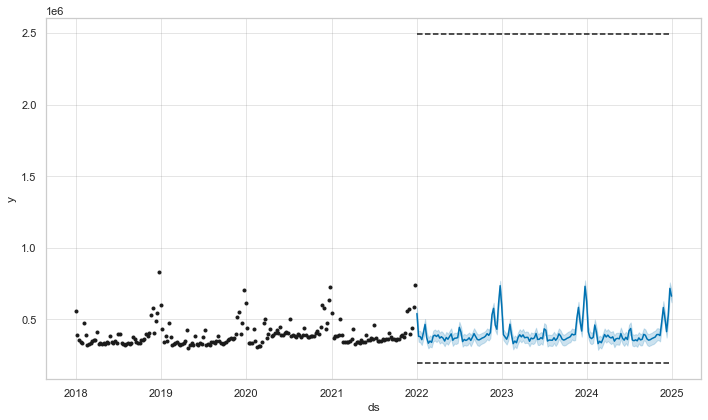

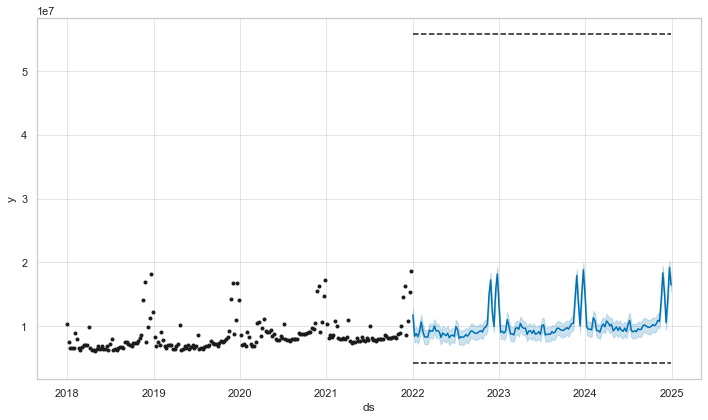

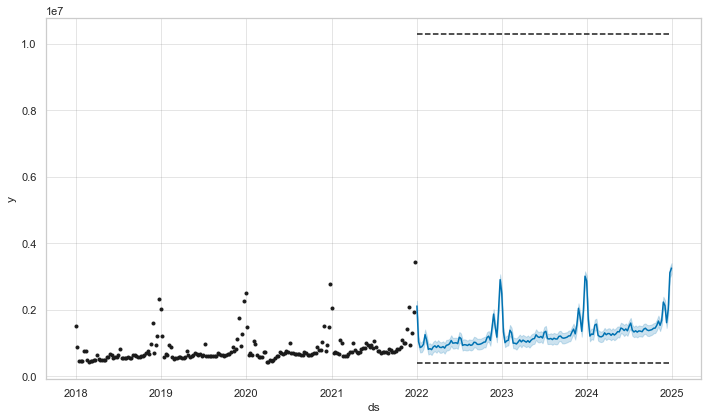

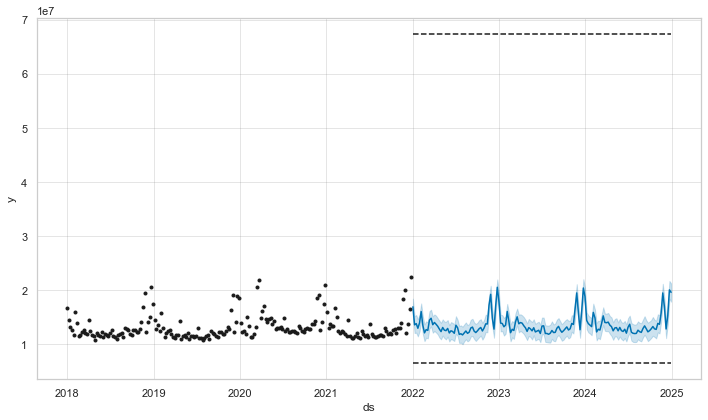

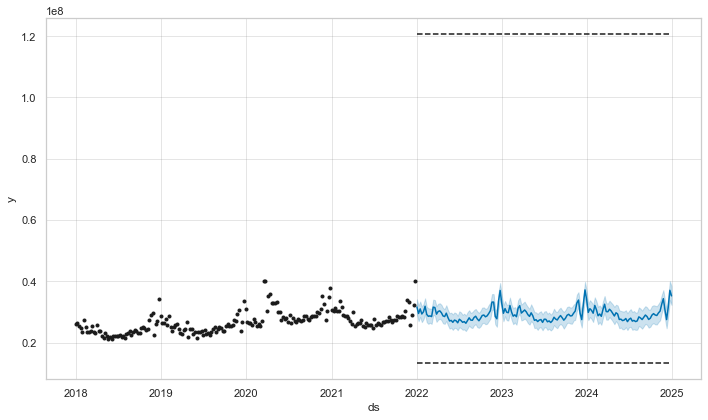

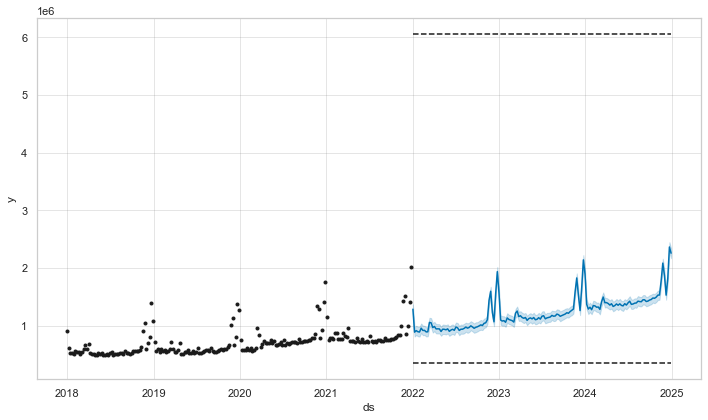

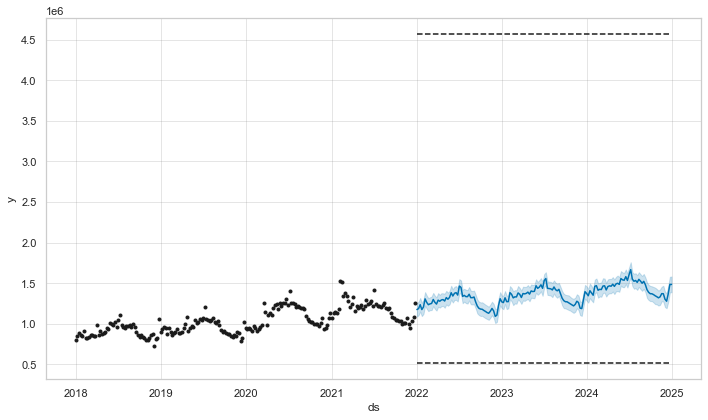

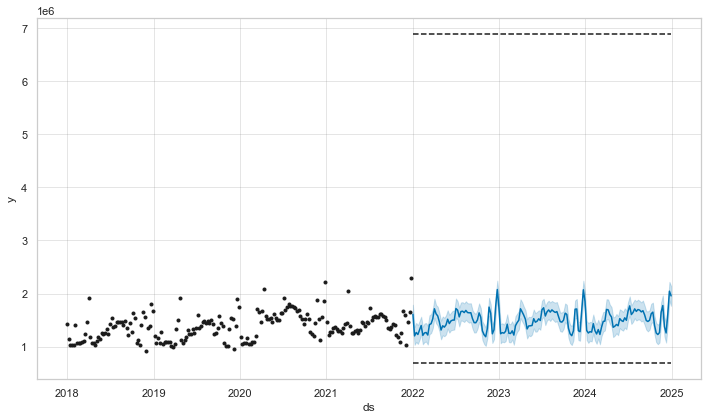

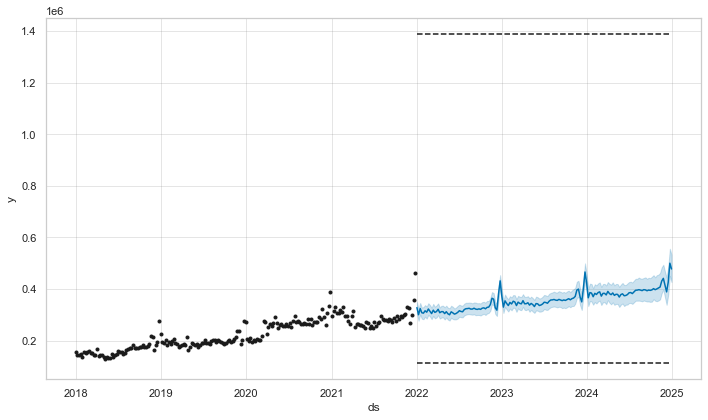

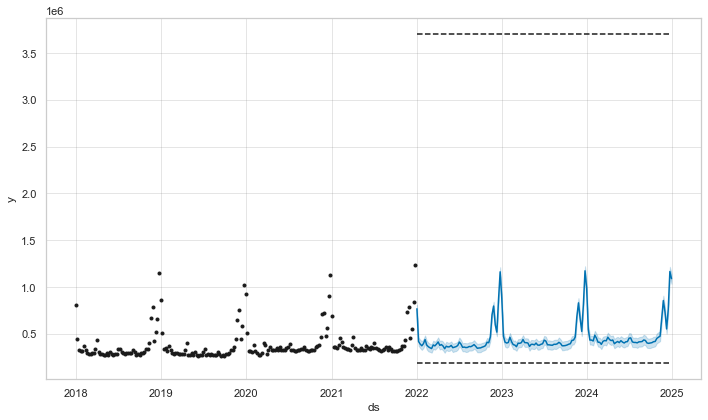

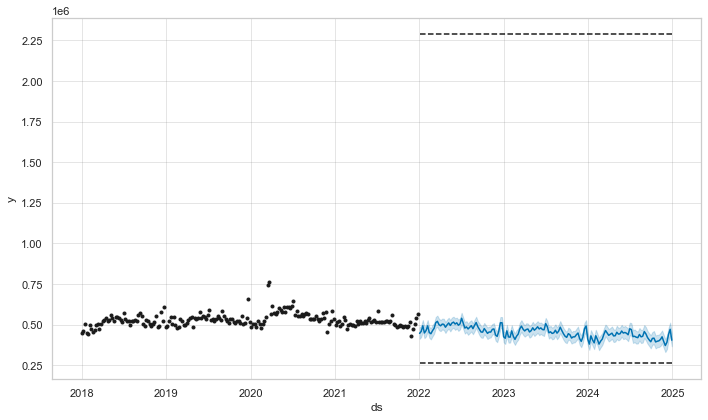

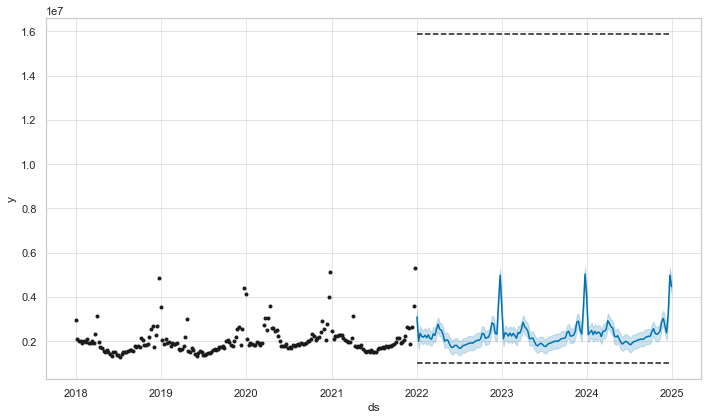

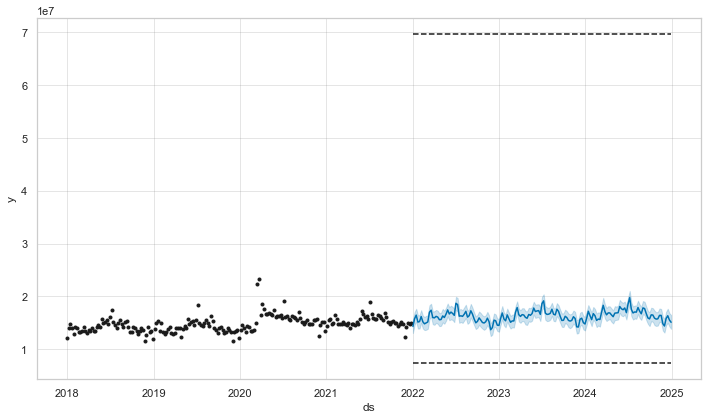

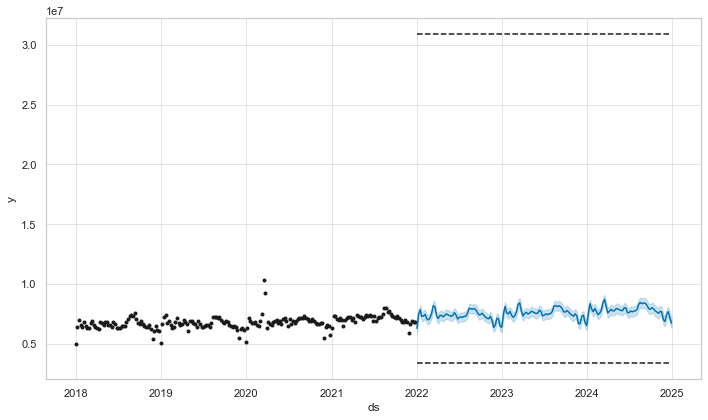

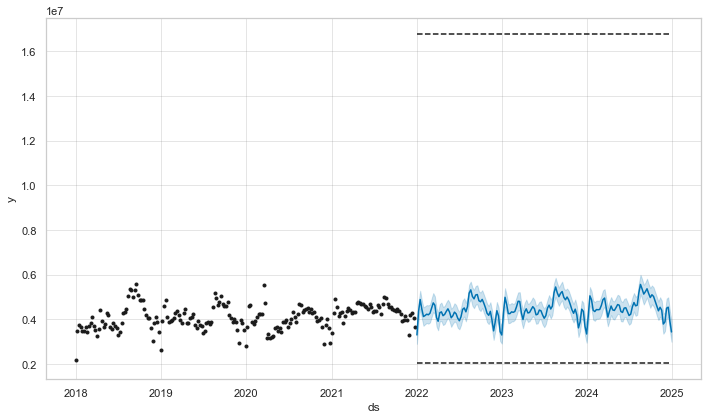

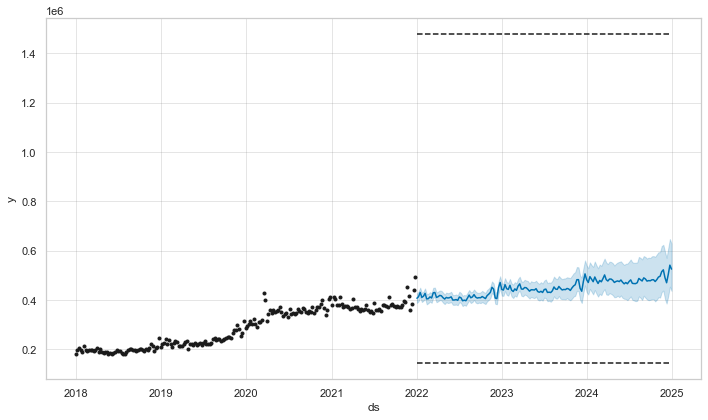

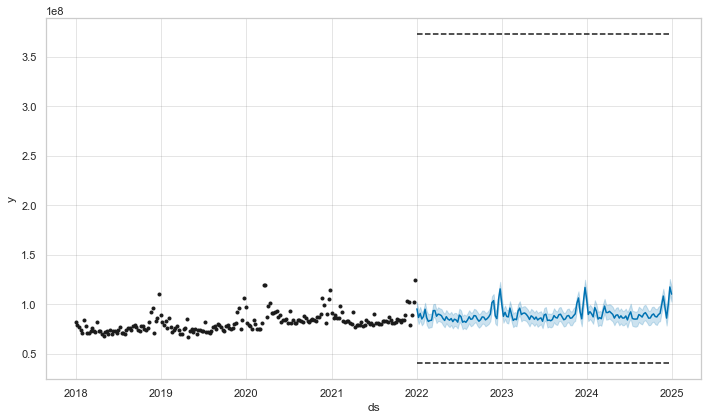

In [190]:
df_markets_fcst_res = forecasting_markets(df_markets, features_markets, periods=157, freq='W')

In [191]:
df_markets_fcst_res.tail()

,Date,CLASSIC SPREADS,CREAM CHEESE,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS,PLANT BASED,TOTAL CHEESE
361,2024-12-01,506397.333766,1.519785e+07,2.122261e+06,1.687773e+07,3.067466e+07,1.870059e+06,1.301801e+06,1.373074e+06,414676.020986,7.367941e+05,371665.260218,2.681912e+06,1.439668e+07,6.867231e+06,3.890903e+06,491237.461021,9.703500e+07
362,2024-12-08,413647.186835,1.056272e+07,1.611919e+06,1.283889e+07,2.750147e+07,1.529257e+06,1.276845e+06,1.256162e+06,388689.328722,5.531199e+05,391591.021332,2.371018e+06,1.582035e+07,7.449945e+06,4.502864e+06,470592.352079,8.617600e+07
363,2024-12-15,528515.964742,1.424246e+07,2.017617e+06,1.532967e+07,3.152989e+07,1.818589e+06,1.367324e+06,1.607244e+06,426448.257832,7.602027e+05,440230.160562,3.262515e+06,1.633962e+07,7.680419e+06,4.547871e+06,503562.042808,9.961981e+07
364,2024-12-22,715995.326888,1.920769e+07,3.113747e+06,2.006978e+07,3.706013e+07,2.363986e+06,1.483431e+06,2.043882e+06,499898.300931,1.166489e+06,471610.882957,4.981537e+06,1.553703e+07,7.172614e+06,3.926609e+06,541905.076741,1.175743e+08
365,2024-12-29,661953.317692,1.648699e+07,3.252846e+06,1.961573e+07,3.524565e+07,2.256441e+06,1.483262e+06,1.955496e+06,477563.940984,1.090894e+06,404474.076375,4.467345e+06,1.509974e+07,6.746763e+06,3.439219e+06,525857.774756,1.103597e+08


0     2017-12-31
1     2018-01-07
2     2018-01-14
3     2018-01-21
4     2018-01-28
         ...    
361   2024-12-01
362   2024-12-08
363   2024-12-15
364   2024-12-22
365   2024-12-29
Name: Date, Length: 366, dtype: datetime64[ns]

In [219]:
df_markets_fcst_res.assign(Year=pd.to_datetime(df_markets_fcst_res.Date).dt.year).groupby('Year').sum().T.to_clipboard()

In [197]:
df_markets_fcst_res['Date'] = df_markets_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_markets_fcst_res.round(1).to_excel("./results/usa_markets_forecasts_ok.xlsx", index=False)

In [76]:
df_markets_results = pd.merge(df_gourmet_fcst_res, df_markets_fcst_res, on='Date')
df_markets_results.tail()

,Date,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,CLASSIC SPREADS,CREAM CHEESE BLOCKS,CREAM CHEESE TUBS,ENTERTAINING TRAYS,...,EVERYDAY SHREDDED & GRATED,GOURMET,PIMENTO,RICOTTA AND FARMERS,SINGLE SERVE,SLICES,SNACK,SNACKING COMBOS,PLANT BASED,TOTAL CHEESE
361,2024-12-01,1.427448e+06,797798.310339,1.276152e+06,332751.871991,640425.132686,457319.756492,9.335321e+06,3.959608e+06,1.645872e+06,...,2.821070e+07,4.607664e+06,336115.187332,2.122262e+06,609.315736,1.422315e+07,7.314728e+06,4.581783e+06,479116.276372,9.314850e+07
362,2024-12-08,1.411002e+06,793358.807713,1.263219e+06,336799.541064,669862.273462,466362.910776,8.745482e+06,3.966325e+06,1.732246e+06,...,2.778234e+07,4.608752e+06,351566.226454,2.474562e+06,604.470550,1.419426e+07,7.373626e+06,4.727702e+06,474500.465954,9.188077e+07
363,2024-12-15,1.567934e+06,844270.306676,1.478951e+06,361769.869095,822161.719547,539899.423552,9.612026e+06,4.139455e+06,2.167063e+06,...,2.971123e+07,5.210300e+06,379563.625557,3.285347e+06,440.605670,1.436223e+07,7.360306e+06,4.614616e+06,487486.689125,9.793698e+07
364,2024-12-22,1.770080e+06,919427.255980,1.726741e+06,388134.488146,979540.584813,616995.884305,1.091916e+07,4.324110e+06,2.663926e+06,...,3.226533e+07,5.918810e+06,391749.670678,3.917995e+06,96.886920,1.462187e+07,7.283961e+06,4.326532e+06,507043.058425,1.059140e+08
365,2024-12-29,1.791477e+06,961966.501930,1.731182e+06,391959.910474,970586.778792,606311.259774,1.061566e+07,4.324926e+06,2.744565e+06,...,3.280496e+07,5.981270e+06,371538.883583,3.784911e+06,-102.376548,1.482039e+07,7.307407e+06,4.214736e+06,516293.924305,1.068928e+08


In [78]:
df_markets_results = df_markets_results[['Date', 'GOURMET BLOCK / WEDGE / ROUND', 'GOURMET CRUMBLED',
       'GOURMET FRESH ITALIAN', 'GOURMET SHREDDED / GRATED', 'GOURMET SPREADS', 'GOURMET',
       'CLASSIC SPREADS', 'CREAM CHEESE BLOCKS', 'CREAM CHEESE TUBS',
       'ENTERTAINING TRAYS', 'EVERYDAY BLOCKS', 'EVERYDAY SHREDDED & GRATED',
       'PIMENTO', 'RICOTTA AND FARMERS', 'SINGLE SERVE', 'SLICES',
       'SNACK', 'SNACKING COMBOS', 'PLANT BASED', 'TOTAL CHEESE']]

In [79]:
df_markets_results['Date'] = df_markets_results.Date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [80]:
df_markets_results.to_excel("./results/usa_markets_forecasts.xlsx", index=False)

## Growth Drivers Past

- Distribution per : mean
- Price per volume per category : mean
- Competition price per category : mean
- Competition sales per category : sum


In [72]:
def growth_drivers(df_bel, df_markets, df_competition_brands, brands_name, brands_markets, controllable_features=False):
    dict_res = {'xgb_feature_importance': {}, 'permutation_importance': {}}
    competition_feats_cat = ['Competition price', 'Competition sales']
    compet_feats = []
    for brand in tqdm(brands_name, ascii=True, desc='Brands'):
        # Competition features
        feats_cat = [feat+'_'+cat for cat in brands_markets[brand] 
                     for feat in competition_feats_cat]
        
        df_tmp = df_bel[df_bel.Brand == brand]
        
        if not controllable_features:
            df_tmp = pd.merge(df_tmp, df_competition_brands[['Date'] + feats_cat], on='Date')
            df_tmp = pd.merge(df_tmp, df_markets[['Date'] + brands_markets[brand]], on='Date')
        
        if len(df_tmp) == 0:
            continue
        
        # Add competition features if df_tmp is not empty (eg: NURISHH for 2019, 2020, etc...) 
        compet_feats += feats_cat
        
        for key in dict_res:
            dict_res[key][brand] = {}
        
        df_tmp_X = df_tmp.drop(['Date', 'Brand', 'Sales in volume'], axis=1)
        X = df_tmp_X.values
        y = df_tmp['Sales in volume']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
        xgb_model = XGBRegressor()
        xgb_model.fit(X_train, y_train)

        # XGB Feature importance
        feature_importances = xgb_model.feature_importances_
        sorted_idx_feat_imp = feature_importances.argsort()
        perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=25)
        sorted_idx_perm_imp = perm_importance.importances_mean.argsort()
        for idx_fi, idx_pi in zip(sorted_idx_feat_imp, sorted_idx_perm_imp):
            dict_res['xgb_feature_importance'][brand][df_tmp_X.columns[idx_fi]] = feature_importances[idx_fi] * 100
            dict_res['permutation_importance'][brand][df_tmp_X.columns[idx_pi]] = perm_importance['importances_mean'][idx_pi] * 100

    # Set compet feats, cause many brands are in the same markets. 
    # np.delete, in order to remove 'Sales in volume', and [2:], to remove Date and Brand
    if controllable_features:
        ordered_drivers = list(df_bel.columns[2:-1])
    else:
        bel_markets = list(set([elem for brand in dict_res['xgb_feature_importance'] for elem in brands_markets[brand]]))
        ordered_drivers = bel_markets + list(set(compet_feats)) + list(df_bel.columns[2:-1])
    print(ordered_drivers)
    for dict_imp in dict_res:
        dict_res[dict_imp] = pd.DataFrame(dict_res[dict_imp]).loc[ordered_drivers]
        
    return dict_res

def compute_growth_drivers_past(df, df_bel, brands_name, features, years=[2018, 2019, 2020, 2021], controllable_features=False):
    """
    """

    brands_markets = {brand: df[df.Brand == brand].Category.unique().tolist() for brand in brands_name}
    # Get markets dataframe
    df_markets = get_df_markets(df)
    # Computing competition price and sales for bel brands
    df_competition_brands = get_df_competition_brands(df, brands_name, features)
    df_competition_brands = df_competition_brands.groupby(['Date', 'Category']).agg(
        {'Price per volume': np.mean, 
         'Sales in volume':  np.sum}).unstack().rename(
        columns={'Price per volume': 'Competition price', 'Sales in volume': 'Competition sales'})
    df_competition_brands.columns = ['_'.join(elem) for elem in df_competition_brands.columns]
    df_competition_brands = df_competition_brands.reset_index()
    dict_res = {year:{} for year in years}
    
    for year in tqdm(years, ascii=True, desc='Years'):
        df_bel_year = df_bel[df_bel.Date.astype('datetime64[ns]').dt.year == year]
        df_compet_year = df_competition_brands[df_competition_brands.Date.astype('datetime64[ns]').dt.year == year]
        df_markets_year = df_markets[df_markets.Date.astype('datetime64[ns]').dt.year == year]
        
        dict_res[year] = growth_drivers(df_bel_year, df_markets_year, 
                                        df_compet_year, brands_name, brands_markets, 
                                        controllable_features=controllable_features)
        
    dict_res['all'] = growth_drivers(df_bel, df_markets, df_competition_brands, 
                                     brands_name, brands_markets, 
                                     controllable_features=controllable_features)
    
    return dict_res

In [69]:
df_bel.head()

,Date,Brand,Price per volume,Sales in volume,Sales in value,Distribution,Sell-in,Advertising,Promotion,A&P,MVC,Rate of Innovation,Promo Cost,HH,Trends
0,2017-12-31,BABYBEL,11.307482,250446.559440,2.831920e+06,417.403475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
1,2017-12-31,BOURSIN,13.745852,85626.196096,1.177005e+06,152.674082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
2,2017-12-31,KAUKAUNA,6.703015,444672.382865,2.792992e+06,173.183200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43
3,2017-12-31,MERKTS,5.383924,88166.774383,4.746832e+05,77.224967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2017-12-31,PRICES,4.762444,108331.433158,5.159224e+05,93.366316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74


In [113]:
bel_features = ['Date', 'Brand', 'A&P', 'Price per volume',
                'Promo Cost', 'HH', 'Rate of Innovation', 'Distribution', 'Trends', 'Sales in volume']
dict_res = compute_growth_drivers_past(
    df, df_bel[bel_features], brands_name[country], features, 
    years=[2018, 2019, 2020, 2021], controllable_features=False)

Years:   0%|          | 0/4 [00:00<?, ?it/s]

Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['PLANT BASED', 'GOURMET SPREADS', 'SNACKING COMBOS', 'CLASSIC SPREADS', 'SNACK', 'PIMENTO', 'Competition price_CLASSIC SPREADS', 'Competition price_GOURMET SPREADS', 'Competition sales_CLASSIC SPREADS', 'Competition sales_GOURMET SPREADS', 'Competition sales_PLANT BASED', 'Competition price_PIMENTO', 'Competition sales_SNACKING COMBOS', 'Competition sales_SNACK', 'Competition price_SNACKING COMBOS', 'Competition price_SNACK', 'Competition price_PLANT BASED', 'Competition sales_PIMENTO', 'A&P', 'Price per volume', 'Promo Cost', 'HH', 'Rate of Innovation', 'Distribution', 'Trends']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['PLANT BASED', 'GOURMET SPREADS', 'SNACKING COMBOS', 'CLASSIC SPREADS', 'SNACK', 'PIMENTO', 'Competition price_CLASSIC SPREADS', 'Competition price_GOURMET SPREADS', 'Competition sales_CLASSIC SPREADS', 'Competition sales_GOURMET SPREADS', 'Competition sales_PLANT BASED', 'Competition price_PIMENTO', 'Competition sales_SNACKING COMBOS', 'Competition sales_SNACK', 'Competition price_SNACKING COMBOS', 'Competition price_SNACK', 'Competition price_PLANT BASED', 'Competition sales_PIMENTO', 'A&P', 'Price per volume', 'Promo Cost', 'HH', 'Rate of Innovation', 'Distribution', 'Trends']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['PLANT BASED', 'GOURMET SPREADS', 'SNACKING COMBOS', 'CLASSIC SPREADS', 'SNACK', 'PIMENTO', 'Competition price_CLASSIC SPREADS', 'Competition price_GOURMET SPREADS', 'Competition sales_CLASSIC SPREADS', 'Competition sales_GOURMET SPREADS', 'Competition sales_PLANT BASED', 'Competition price_PIMENTO', 'Competition sales_SNACKING COMBOS', 'Competition sales_SNACK', 'Competition price_SNACKING COMBOS', 'Competition price_SNACK', 'Competition price_PLANT BASED', 'Competition sales_PIMENTO', 'A&P', 'Price per volume', 'Promo Cost', 'HH', 'Rate of Innovation', 'Distribution', 'Trends']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['PLANT BASED', 'GOURMET SPREADS', 'SNACKING COMBOS', 'CLASSIC SPREADS', 'SNACK', 'PIMENTO', 'Competition price_CLASSIC SPREADS', 'Competition price_GOURMET SPREADS', 'Competition sales_CLASSIC SPREADS', 'Competition sales_GOURMET SPREADS', 'Competition sales_PLANT BASED', 'Competition price_PIMENTO', 'Competition sales_SNACKING COMBOS', 'Competition sales_SNACK', 'Competition price_SNACKING COMBOS', 'Competition price_SNACK', 'Competition price_PLANT BASED', 'Competition sales_PIMENTO', 'A&P', 'Price per volume', 'Promo Cost', 'HH', 'Rate of Innovation', 'Distribution', 'Trends']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['PLANT BASED', 'GOURMET SPREADS', 'SNACKING COMBOS', 'CLASSIC SPREADS', 'SNACK', 'PIMENTO', 'Competition price_CLASSIC SPREADS', 'Competition price_GOURMET SPREADS', 'Competition sales_CLASSIC SPREADS', 'Competition sales_GOURMET SPREADS', 'Competition sales_PLANT BASED', 'Competition price_PIMENTO', 'Competition sales_SNACKING COMBOS', 'Competition sales_SNACK', 'Competition price_SNACKING COMBOS', 'Competition price_SNACK', 'Competition price_PLANT BASED', 'Competition sales_PIMENTO', 'A&P', 'Price per volume', 'Promo Cost', 'HH', 'Rate of Innovation', 'Distribution', 'Trends']


In [114]:
for year in dict_res:
    pd.DataFrame(dict_res[year]['xgb_feature_importance']).round(1).to_excel("results/growth_drivers_past_{}.xlsx".format(year))

In [228]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
xgb_model.get_booster().get_score(importance_type='gain')

{'Price per volume': 0.02084944024682045,
 'AIDE CULINAIRE': 0.009511205367743969,
 'APERITIF & SALADE': 0.013816207647323608,
 'BLEUS & CHEVRES': 0.012448495253920555,
 'BLOC': 0.0030282889492809772,
 'DEGUSTATION': 0.11441913992166519,
 'RAPES': 0.36534491181373596,
 'REPAS CHAUD': 0.005471059586852789,
 'SNACKING': 0.3426344394683838,
 'TARTINES A ETALER': 2.3759751319885254,
 'TARTINES A POSER': 0.007545202970504761,
 'TOTAL CHEESE': 0.008840514346957207}

<Figure size 1152x720 with 0 Axes>

<BarContainer object of 12 artists>

Text(0.5, 0, 'Xgboost Feature Importance')

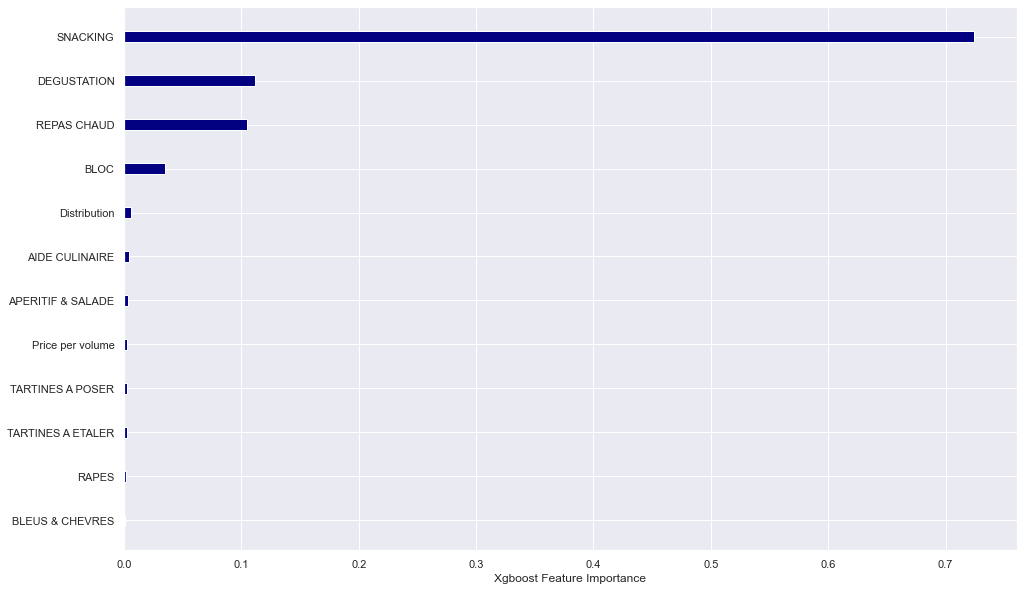

In [233]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(16, 10))
plt.barh(df_gd_past.columns[2:-1][sorted_idx], xgb_model.feature_importances_[sorted_idx], color='navy', height=0.25)
plt.xlabel("Xgboost Feature Importance")

## Growth Drivers Future

In [105]:
df_futures = pd.DataFrame()
for brand in feats_futures:
    df_tmp = pd.merge(feats_futures[brand].rename(columns={'ds':'Date'}), 
                     df_brands_fcst_res[['Date', brand]], on='Date').rename(
        columns={brand: 'Sales in volume'})
    df_tmp['Brand'] = brand
    df_futures = pd.concat([df_futures, df_tmp])

,Date,A&P,Price per volume,Promo Cost,Sales in volume,Brand
0,2017-12-31,0.000000,11.307482,0.000000,250446.559440,BABYBEL
1,2018-01-07,488628.056575,10.935915,0.000000,345687.914295,BABYBEL
2,2018-01-14,488628.056575,10.578783,0.000000,402472.872702,BABYBEL
3,2018-01-21,488628.056575,10.644737,0.000000,384159.741534,BABYBEL
4,2018-01-28,488628.056575,10.612370,0.000000,381713.098609,BABYBEL
...,...,...,...,...,...,...
361,2024-12-01,286423.747709,16.043320,91512.561872,319047.314183,BABYBEL
362,2024-12-08,298316.923024,15.888776,91015.600167,319960.740816,BABYBEL
363,2024-12-15,272162.760427,15.825842,75343.832929,317149.621849,BABYBEL
364,2024-12-22,264171.051384,15.901315,105072.874586,309530.270671,BABYBEL


,Date,A&P,Price per volume,Promo Cost,Sales in volume,Brand
0,2017-12-31,0.000000,11.307482,0.000000,250446.559440,BABYBEL
1,2018-01-07,488628.056575,10.935915,0.000000,345687.914295,BABYBEL
2,2018-01-14,488628.056575,10.578783,0.000000,402472.872702,BABYBEL
3,2018-01-21,488628.056575,10.644737,0.000000,384159.741534,BABYBEL
4,2018-01-28,488628.056575,10.612370,0.000000,381713.098609,BABYBEL
...,...,...,...,...,...,...
361,2024-12-01,-48957.205287,9.223322,93988.834969,322882.013103,THE LAUGHING COW
362,2024-12-08,-24682.651886,9.386827,118204.497322,317202.952403,THE LAUGHING COW
363,2024-12-15,-22936.671361,9.521677,146895.989469,308353.482977,THE LAUGHING COW
364,2024-12-22,-42923.275507,9.599141,184513.019867,304109.577746,THE LAUGHING COW


,Date,A&P,Price per volume,Promo Cost,Sales in volume,Brand
0,2017-12-31,0.000000,11.307482,0.000000,250446.559440,BABYBEL
1,2018-01-07,488628.056575,10.935915,0.000000,345687.914295,BABYBEL
2,2018-01-14,488628.056575,10.578783,0.000000,402472.872702,BABYBEL
3,2018-01-21,488628.056575,10.644737,0.000000,384159.741534,BABYBEL
4,2018-01-28,488628.056575,10.612370,0.000000,381713.098609,BABYBEL
...,...,...,...,...,...,...
361,2024-12-01,377295.313387,18.214476,541642.584675,125469.473303,BOURSIN
362,2024-12-08,364023.811356,18.590730,493896.799306,125365.068019,BOURSIN
363,2024-12-15,369269.130137,18.305538,470110.787539,143696.586620,BOURSIN
364,2024-12-22,346206.226346,17.773609,427965.358617,163964.562755,BOURSIN


,Date,A&P,Price per volume,Promo Cost,Sales in volume,Brand
0,2017-12-31,0.000000,11.307482,0.000000,250446.559440,BABYBEL
1,2018-01-07,488628.056575,10.935915,0.000000,345687.914295,BABYBEL
2,2018-01-14,488628.056575,10.578783,0.000000,402472.872702,BABYBEL
3,2018-01-21,488628.056575,10.644737,0.000000,384159.741534,BABYBEL
4,2018-01-28,488628.056575,10.612370,0.000000,381713.098609,BABYBEL
...,...,...,...,...,...,...
361,2024-12-01,13167.515835,8.463594,145783.710929,246457.460593,KAUKAUNA
362,2024-12-08,7760.070912,8.455374,150662.635287,279253.009143,KAUKAUNA
363,2024-12-15,5241.549717,8.365120,152505.222211,374320.268886,KAUKAUNA
364,2024-12-22,4251.846639,8.324651,138185.626858,462094.472150,KAUKAUNA


,Date,A&P,Price per volume,Promo Cost,Sales in volume,Brand
0,2017-12-31,0.000000,11.307482,0.000000,250446.559440,BABYBEL
1,2018-01-07,488628.056575,10.935915,0.000000,345687.914295,BABYBEL
2,2018-01-14,488628.056575,10.578783,0.000000,402472.872702,BABYBEL
3,2018-01-21,488628.056575,10.644737,0.000000,384159.741534,BABYBEL
4,2018-01-28,488628.056575,10.612370,0.000000,381713.098609,BABYBEL
...,...,...,...,...,...,...
361,2024-12-01,8964.239181,9.629074,16991.484004,40549.131444,MERKTS
362,2024-12-08,4829.360613,9.512270,24490.550754,44653.699961,MERKTS
363,2024-12-15,3779.813130,9.245787,28513.501969,58799.030748,MERKTS
364,2024-12-22,3078.443542,9.062566,25821.364972,72351.355650,MERKTS


,Date,A&P,Price per volume,Promo Cost,Sales in volume,Brand
0,2017-12-31,0.000000,11.307482,0.000000,250446.559440,BABYBEL
1,2018-01-07,488628.056575,10.935915,0.000000,345687.914295,BABYBEL
2,2018-01-14,488628.056575,10.578783,0.000000,402472.872702,BABYBEL
3,2018-01-21,488628.056575,10.644737,0.000000,384159.741534,BABYBEL
4,2018-01-28,488628.056575,10.612370,0.000000,381713.098609,BABYBEL
...,...,...,...,...,...,...
361,2024-12-01,22813.773193,6.086534,15678.841592,20383.209295,PRICES
362,2024-12-08,22827.623961,6.149872,24239.323448,22454.660579,PRICES
363,2024-12-15,22420.370200,6.077639,32113.287533,28231.110610,PRICES
364,2024-12-22,21394.564457,5.977093,33040.442986,32217.836593,PRICES


,Date,A&P,Price per volume,Promo Cost,Sales in volume,Brand
0,2017-12-31,0.000000,11.307482,0.000000,250446.559440,BABYBEL
1,2018-01-07,488628.056575,10.935915,0.000000,345687.914295,BABYBEL
2,2018-01-14,488628.056575,10.578783,0.000000,402472.872702,BABYBEL
3,2018-01-21,488628.056575,10.644737,0.000000,384159.741534,BABYBEL
4,2018-01-28,488628.056575,10.612370,0.000000,381713.098609,BABYBEL
...,...,...,...,...,...,...
188,2024-12-01,97698.687754,-8.211397,-667.055251,1137.490638,NURISHH
189,2024-12-08,98107.481058,-8.330608,-686.247989,1142.732321,NURISHH
190,2024-12-15,98516.274362,-8.449820,-705.440727,1147.974003,NURISHH
191,2024-12-22,98925.067666,-8.569032,-724.633465,1153.215686,NURISHH


In [109]:
dict_res_future = compute_growth_drivers_past(
    df, df_futures[df_futures.Date > df_bel.Date.iloc[-1]][bel_features], brands_name[country], features, 
    years=[2022, 2023, 2024], controllable_features=True)

Years:   0%|          | 0/3 [00:00<?, ?it/s]

Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost']


In [112]:
for year in dict_res_future:
    pd.DataFrame(dict_res_future[year]['xgb_feature_importance']).round(1).to_excel("results/growth_drivers_future_{}_controllable_features.xlsx".format(year))